In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4 as nc

import torch
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import transforms

from utils import *
from model import get_model

from sklearn.metrics import roc_auc_score, confusion_matrix
from torchvision.ops import sigmoid_focal_loss
from torch.nn.functional import binary_cross_entropy_with_logits

In [2]:
# ====== 실험 설정 ====== # 중요함
seeds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# 사용할 데이터 종류 설정, 단일 학습인지 멀티테스크인지 설정 (URP 에서 AAFOS FALSE 설정)
ASOS = True
AAFOS = False
assert ASOS or AAFOS, "At least one of ASOS or AAFOS must be True."

channels = '16ch' # '16ch' or 'ae304', 16ch일때 [16,512,512]
time_range = [-12]
resolution = '2km' # '1km':1024 or '2km':512
postfix = 'baseline_prediction'

output_path = "results/"
output_path += 'asos_' if ASOS else ''
output_path += 'aafos_' if AAFOS else ''
output_path += channels + '_'
output_path += 'time' + str(time_range) + '_'
output_path += resolution
output_path += ('_' + postfix) if postfix != '' else postfix
print(f"Output path name: {output_path}")

# 기본 asos:aafos 비율 5:1
asos_aafos_ratio = 5.0
asos_weight = asos_aafos_ratio / (asos_aafos_ratio + 1.0 * AAFOS) if ASOS else 0.0
aafos_weight = 1.0 / (asos_aafos_ratio * ASOS + 1.0) if AAFOS else 0.0
print(f"ASOS weight: {asos_weight:.2f}, AAFOS weight: {aafos_weight:.2f}")

# 기타 ablation 설정
latlon = False

# 실험중인 설정들
central_patch = False
use_patch = False

#  ====== 채널 설정 ====== #
if channels == '16ch':
    channels_name = ['vi004','vi005','vi006','vi008','nr013','nr016','sw038','wv063','wv069','wv073','ir087','ir096','ir105','ir112','ir123','ir133'] # 시각화 용
    channels_calib = ['vi004','vi005','vi006','vi008','nr013','nr016','sw038','wv063','wv069','wv073','ir087','ir096','ir105','ir112','ir123','ir133']
    
    channels_mean = [1.1912e-01, 1.1464e-01, 1.0734e-01, 1.2504e-01, 5.4983e-02, 9.0381e-02,
                2.7813e+02, 2.3720e+02, 2.4464e+02, 2.5130e+02, 2.6948e+02, 2.4890e+02,
                2.7121e+02, 2.7071e+02, 2.6886e+02, 2.5737e+02]
    channels_std  = [0.1306,  0.1303,  0.1306,  0.1501,  0.0268,  0.0838, 15.8211,  6.1468,
                7.8054,  9.3251, 16.4265,  9.6150, 17.2518, 17.6064, 17.0090, 12.5026]

else:
    raise ValueError("Invalid channels.")


train_data_info_list = []
train_data_info_list.append({
    'label_type': 'asos', # 'asos' or 'aafos'
    'start_date_str': '20200101', #  라벨기준 일자. KST
    'end_date_str': '20230630',
    'hour_col_pairs': [(6,'AM')],
    'label_keys': ['93','108','112','119','131','133','136','143','146','156','177','102','104','115','138','152','155','159','165','168','169','184','189']
}) if ASOS else None

test_asos_data_info_list = [
    {
        'label_type': 'asos', # 'asos' or 'aafos'
        'start_date_str': '20230701', #  라벨기준 일자. KST
        'end_date_str': '20240630',
        'hour_col_pairs': [(6,'AM')],
        'label_keys': ['93','108','112','119','131','133','136','143','146','156','177','102','104','115','138','152','155','159','165','168','169','184','189']
    },
] if ASOS else None


origin_size = 900 if resolution == '2km' else 1800
image_size = 512 if resolution == '2km' else 1024
patch_size = 512

data_path = '../data/date_kst_URP'

misc_channels = {
    'elevation':'elevation_1km_3600.npy',
    'vegetation':'vegetation_1km_3600.npy',
    'watermap':'watermap_1km_avg_3600.npy'
}
lat_lon_path = 'assets/gk2a_ami_ko010lc_latlon.nc'

# 학습과 관련된 설정! 변경 시 주의 요함
batch_size = 64
num_workers = 8

epochs = 25
lr = 1e-3
decay = [10, 20]
lr_decay = 0.1
weight_decay = 1e-5
threshold = [0.25]

# 자동으로 설정되는 값
asos_x_base, asos_y_base, asos_image_size = get_crop_base(image_size, label_type='asos')
aafos_x_base, aafos_y_base, aafos_image_size = get_crop_base(image_size, label_type='aafos')
aafos_x_base -= asos_x_base
aafos_y_base -= asos_y_base

total_channels = len(channels_name) * len(time_range) + len(misc_channels.keys())
total_channels += 2 if latlon else 0
print(total_channels)

Output path name: results/asos_16ch_time[-12]_2km_baseline_prediction
ASOS weight: 1.00, AAFOS weight: 0.00
19


dict_keys([93, 108, 112, 119, 131, 133, 136, 143, 146, 156, 177, 102, 104, 115, 138, 152, 155, 159, 165, 168, 169, 184, 189])


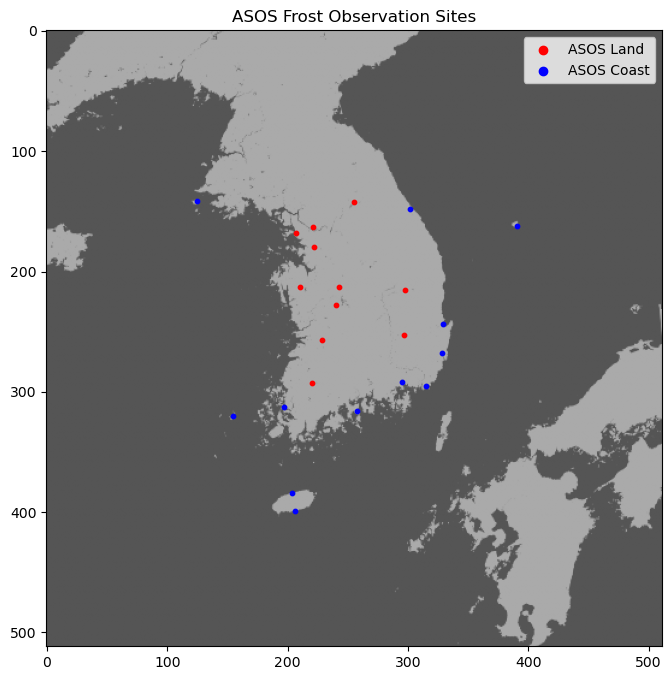

In [3]:
asos_land_map = {k: coord_to_map(*v, origin_size) for k, v in ASOS_LAND_COORD.items()}
asos_land_map = {k: (v[0]-asos_x_base, v[1]-asos_y_base) for k, v in asos_land_map.items()}
asos_coast_map = {k: coord_to_map(*v, origin_size) for k, v in ASOS_COAST_COORD.items()}
asos_coast_map = {k: (v[0]-asos_x_base, v[1]-asos_y_base) for k, v in asos_coast_map.items()}
asos_map_dict = {**asos_land_map, **asos_coast_map}
print(asos_map_dict.keys())


image = np.load('assets/misc_channels/watermap_1km_avg_3600.npy', allow_pickle=True)
image = -image + 1.0
image = cv2.resize(image, (asos_image_size, asos_image_size), interpolation=cv2.INTER_CUBIC)

plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray', vmin=-1, vmax=2)

for k, v in asos_land_map.items():
    plt.scatter(v[0], v[1], c='r', marker='o', s=10)
for k, v in asos_coast_map.items():
    plt.scatter(v[0], v[1], c='b', marker='o', s=10)

    
plt.scatter([], [], c='r', marker='o', label='ASOS Land')
plt.scatter([], [], c='b', marker='o', label='ASOS Coast')

    
plt.title('ASOS Frost Observation Sites')
plt.legend()
plt.show()

In [4]:
if channels_mean is None:
    date_list = os.listdir(data_path)
    date_list = [date for date in date_list if '20200101' <= date < '20240101']

    npy_list = []
    for date in tqdm(date_list[::10]):
        for file in os.listdir(os.path.join(data_path, date)):
            if channels not in file:
                continue
            npy = np.load(os.path.join(data_path, date, file), allow_pickle=True).astype(np.float32) # (C, H, W)
            npy_list.append(npy)
    npy_array = np.stack(npy_list, axis=0)
    print(npy_array.shape) # (N, C, H, W)

    channels_mean = npy_array.mean(axis=(0,2,3)).tolist()
    channels_std = npy_array.std(axis=(0,2,3)).tolist()

channels_mean = channels_mean * len(time_range)
channels_std = channels_std * len(time_range)

print(channels_mean)
print(channels_std)

[0.11912, 0.11464, 0.10734, 0.12504, 0.054983, 0.090381, 278.13, 237.2, 244.64, 251.3, 269.48, 248.9, 271.21, 270.71, 268.86, 257.37]
[0.1306, 0.1303, 0.1306, 0.1501, 0.0268, 0.0838, 15.8211, 6.1468, 7.8054, 9.3251, 16.4265, 9.615, 17.2518, 17.6064, 17.009, 12.5026]


In [5]:
lat_lon_data = nc.Dataset(lat_lon_path)
lat = lat_lon_data['lat'][:].data
lon = lat_lon_data['lon'][:].data

lat = cv2.resize(lat, (origin_size, origin_size), interpolation=cv2.INTER_CUBIC)
lon = cv2.resize(lon, (origin_size, origin_size), interpolation=cv2.INTER_CUBIC)
print(lat.shape, lon.shape)

asos_lat = lat[asos_y_base:asos_y_base+asos_image_size, asos_x_base:asos_x_base+asos_image_size]
asos_lon = lon[asos_y_base:asos_y_base+asos_image_size, asos_x_base:asos_x_base+asos_image_size]
print(asos_lat.shape, asos_lon.shape)


lcc = ccrs.LambertConformal(central_longitude=126, central_latitude=38, standard_parallels = (30,60))
proj = ccrs.PlateCarree()

(900, 900) (900, 900)
(512, 512) (512, 512)


MISC images shape: torch.Size([3, 512, 512])
Total mean: [0.11912, 0.11464, 0.10734, 0.12504, 0.054983, 0.090381, 278.13, 237.2, 244.64, 251.3, 269.48, 248.9, 271.21, 270.71, 268.86, 257.37, 73.77144622802734, 0.13837116956710815, 0.7484566569328308]
Total std: [0.1306, 0.1303, 0.1306, 0.1501, 0.0268, 0.0838, 15.8211, 6.1468, 7.8054, 9.3251, 16.4265, 9.615, 17.2518, 17.6064, 17.009, 12.5026, 193.6297149658203, 0.2834540903568268, 0.4278273582458496]


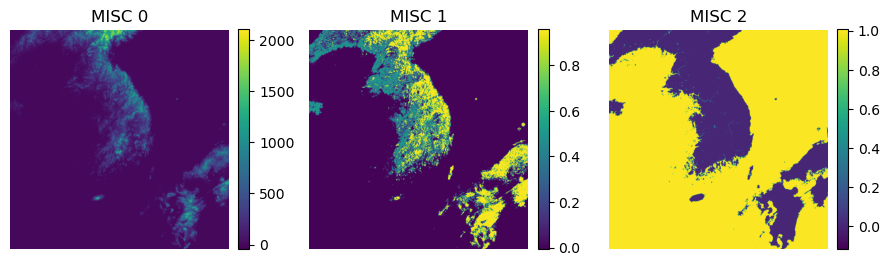

In [6]:
"""
MISC 0: Elevation (고도)
MISC 1: Water Bodies Index (수역 여부)
MISC 2: Vegetation Index (식생 여부)
"""
misc_images = []
for misc_channel, misc_path in misc_channels.items():
    misc_image = np.load(f'assets/misc_channels/{misc_path}', allow_pickle=True)
    misc_image = cv2.resize(misc_image, (asos_image_size, asos_image_size), interpolation=cv2.INTER_CUBIC)
    misc_images.append(misc_image)
misc_images = np.stack(misc_images, axis=0)
misc_images = torch.tensor(misc_images, dtype=torch.float32)

if latlon:
    lat_image = cv2.resize(asos_lat, (asos_image_size, asos_image_size), interpolation=cv2.INTER_CUBIC)
    lon_image = cv2.resize(asos_lon, (asos_image_size, asos_image_size), interpolation=cv2.INTER_CUBIC)
    
    lat_image = torch.tensor(lat_image, dtype=torch.float32).unsqueeze(0)
    lon_image = torch.tensor(lon_image, dtype=torch.float32).unsqueeze(0)
    misc_images = torch.cat([misc_images, lat_image, lon_image], dim=0)

print(f'MISC images shape: {misc_images.shape}')

# normalize by channel
misc_mean = misc_images.mean(dim=[1,2], keepdim=True)
misc_std = misc_images.std(dim=[1,2], keepdim=True)

total_mean = channels_mean + misc_mean.squeeze().tolist()
total_std = channels_std + misc_std.squeeze().tolist()

print(f'Total mean: {total_mean}')
print(f'Total std: {total_std}')

fig, axs = plt.subplots(math.ceil(misc_images.shape[0]/3), 3, figsize=(9, 5))
for i in range(misc_images.shape[0]):
    ax = axs.flatten()[i]
    ax.imshow(misc_images[i].numpy(), cmap='viridis')
    ax.set_title(f'MISC {i}')
    colorbar = plt.colorbar(mappable=ax.images[0], ax=ax, fraction=0.046, pad=0.04)
    ax.axis('off')
for i in range(misc_images.shape[0], len(axs.flatten())):
    ax = axs.flatten()[i]
    ax.axis('off')
plt.tight_layout()
plt.show()

ASOS patch candidates: [[0 0]]


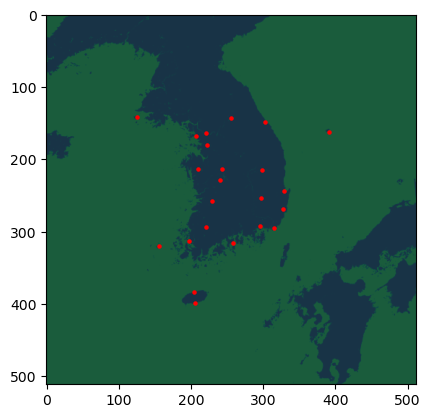

In [7]:
asos_patch_candidate = np.zeros([image_size, image_size], dtype=np.uint8)
for x, y in asos_map_dict.values():
    y_min = np.clip(y - 3*patch_size//4, 0, image_size - patch_size+1)
    y_max = np.clip(y - patch_size//4, 0, image_size - patch_size+1)   
    x_min = np.clip(x - 3*patch_size//4, 0, image_size - patch_size+1)
    x_max = np.clip(x - patch_size//4, 0, image_size - patch_size+1)
    asos_patch_candidate[y_min:y_max, x_min:x_max] = 1
    plt.scatter(x, y, c='r', marker='o', s=5)
plt.imshow(misc_images[2], cmap='viridis', vmin=-1, vmax=2)
plt.imshow(asos_patch_candidate, cmap='gray', vmin=0, vmax=1, alpha=0.5)
asos_patch_candidate = np.argwhere(asos_patch_candidate == 1)[:, [1, 0]]
print(f'ASOS patch candidates: {asos_patch_candidate}')
plt.show()


patch_candidates = {
    'asos': asos_patch_candidate}

In [8]:
transform = transforms.Compose([
    transforms.Normalize(mean=total_mean, std=total_std)
])

train_dataset = GK2ADataset(data_path=data_path, output_path=output_path, data_info_list=train_data_info_list,
                            channels=channels, time_range=time_range, channels_calib=channels_calib, image_size=image_size, misc_images=misc_images,
                            patch_size=patch_size, patch_candidates=patch_candidates, transform=transform, train=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)

if ASOS:
    test_asos_dataset = GK2ADataset(data_path=data_path, output_path=output_path, data_info_list=test_asos_data_info_list,
                            channels=channels, time_range=time_range, channels_calib=channels_calib, image_size=image_size, misc_images=misc_images,
                            patch_size=patch_size, patch_candidates=None, transform=transform, train=False)
    test_asos_dataloader = DataLoader(test_asos_dataset, batch_size=batch_size//2, shuffle=False, num_workers=num_workers, drop_last=False)


== Preparing asos...



Processing asos:   1%|▎                                          | 11/1277 [00:00<00:11, 109.12it/s]

  - 20200101 AM skipped, 2019-12-31 18:00:00 not in date_table


Processing asos:  51%|█████████████████████▎                    | 649/1277 [00:03<00:01, 400.51it/s]

  - 20211003 AM skipped, 2021-10-02 18:00:00 not in date_table


Processing asos: 100%|█████████████████████████████████████████| 1277/1277 [00:07<00:00, 177.56it/s]



  - Total 1275 image-label pairs prepared
  - train_asos_image_label_list.yaml saved

== asos dataset length synced to 1275
GK2A Dataset initialized


== Preparing asos...



Processing asos: 100%|███████████████████████████████████████████| 366/366 [00:02<00:00, 157.16it/s]



  - Total 366 image-label pairs prepared
  - test_asos_image_label_list.yaml saved

== asos dataset length synced to 366
GK2A Dataset initialized




Dataset patchfy set to True.

torch.Size([19, 512, 512]) torch.Size([23]) (2,)


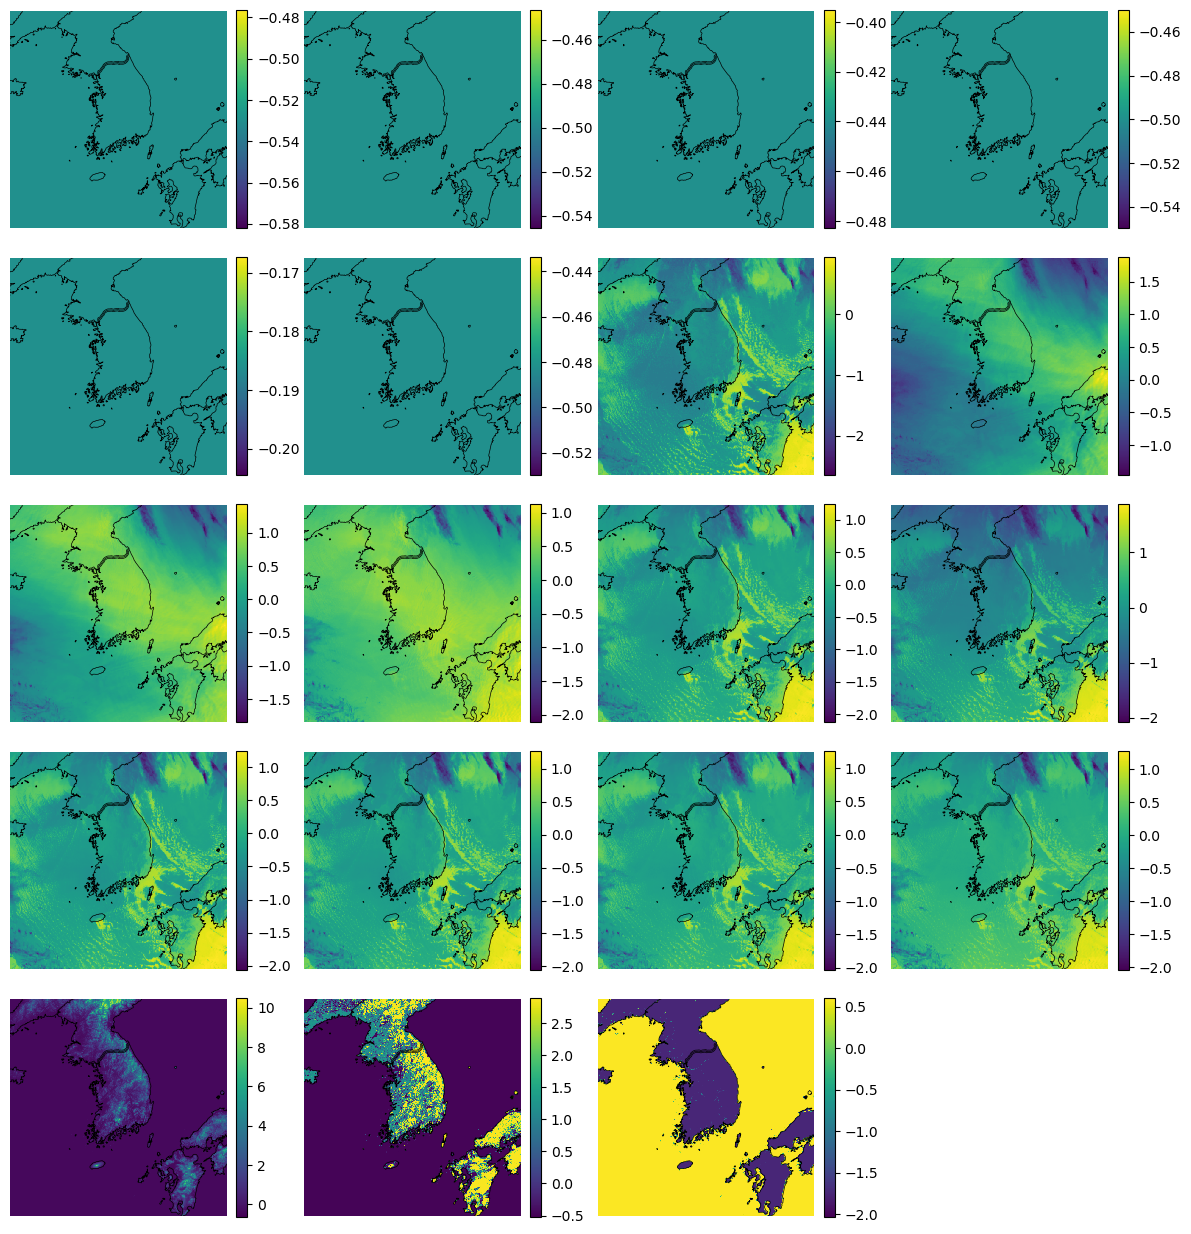

In [9]:
train_dataset.patchfy(True)
batch = train_dataset[7]
for i in range(len(batch)):
    images, label, coords = batch[i]
    print(images.shape, label.shape, coords.shape)

    fig, axs = plt.subplots(math.ceil(images.shape[0]/4), 4, figsize=(12, 2.5 * math.ceil(images.shape[0]/4)), subplot_kw={'projection': lcc})
    for i in range(len(axs.flatten())):
        ax = axs.flatten()[i]
        if i >= images.shape[0]:
            ax.axis('off')
            continue
        
        # channel = total_channels[i]
        # ax.set_title(channel)

        image = np.ones((asos_image_size, asos_image_size), dtype=np.float32)
        image *= -1.0
        image[coords[1]:coords[1]+patch_size, coords[0]:coords[0]+patch_size] = images[i].numpy()

        ax.set_aspect('equal')
        ax.axis('off')
        
        im = ax.pcolormesh(asos_lon, asos_lat, image, cmap='viridis', transform=proj)
            
        ax.coastlines(resolution='10m', color='black', linewidth=0.5)
        ax.add_feature(cfeature.BORDERS.with_scale('10m'), edgecolor='black', linewidth=0.5)

        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
    plt.tight_layout()
    plt.show()

In [ ]:
model = get_model(total_channels, patch_size, 'predformer')
model

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(19, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

In [11]:
def calc_measure_valid(Y_test, Y_test_hat, cutoff=0.5):
    Y_test = Y_test.ravel()
    Y_test_hat = Y_test_hat.ravel()
    
    Y_valid = (~np.isnan(Y_test))
    Y_test = Y_test[Y_valid]
    Y_test_hat = Y_test_hat[Y_valid]

    cfmat = confusion_matrix(Y_test, Y_test_hat > cutoff, labels = [0,1])
    acc = np.trace(cfmat) / np.sum(cfmat)
    csi = cfmat[1,1] /(np.sum(cfmat) - cfmat[0,0] + 1e-8)
    
    try:
        auroc = roc_auc_score(Y_test, Y_test_hat)
    except Exception as e:
        auroc = 0.0

    return csi, acc, auroc

In [12]:
def train(model, images, labels, coords, map_dict, cls_num=0):
    images = images.cuda()
    labels = labels.cuda()

    pred_map = model.forward(images)[:, cls_num] # B, H, W
    pred_vec = torch.zeros_like(labels)
    for b, (px, py) in enumerate(coords):
        for i, (x, y) in enumerate(map_dict.values()):
            if px <= x < px + patch_size and py <= y < py + patch_size:
                pred_vec[b, i] = pred_map[b, y - py, x - px]
            else:
                pred_vec[b, i] = labels[b, i]

    labels_valid = (~torch.isnan(labels)).float()
    labels = torch.nan_to_num(labels, 0.0)

    loss_focal_raw = sigmoid_focal_loss(pred_vec, labels, alpha=-1, gamma=2, reduction='none')
    loss_focal = (loss_focal_raw * labels_valid).sum() / labels_valid.sum().clamp(min=1.0)
    valid_any_batch = (labels_valid.sum() > 0)
    all_zero_batch = ((labels * labels_valid).sum() == 0)
                
    if not (valid_any_batch and all_zero_batch):
        loss_non_frost = torch.tensor(0.0, device=labels.device)
    else:
        loss_non_frost = binary_cross_entropy_with_logits(
                        pred_map, torch.zeros_like(pred_map), reduction='mean'
                    )

    tp = torch.sum(torch.sigmoid(pred_vec) * labels * labels_valid, dim=0)
    fn = torch.sum((1-torch.sigmoid(pred_vec)) * labels * labels_valid, dim=0)
    fp = torch.sum(torch.sigmoid(pred_vec) * (1-labels) * labels_valid, dim=0)
                
    loss_csi = torch.mean(-torch.log(tp + 1e-10) + torch.log(tp + fn + fp + 1e-10)) # csi = tp / (tp + fn + fp)

    return loss_focal + loss_non_frost + loss_csi
    

for seed in seeds:
    if os.path.exists(f'{output_path}/{seed}/ckpt.pt'):
        print(f'Seed {seed} already done. Skipping...')
        continue
    
    model = get_model(total_channels, patch_size)
    model.cuda()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=decay, gamma=lr_decay)

    start_epoch = 0
    
    results = dict(
            loss = {'asos': [], 'aafos': [], 'total': []},
            csi = {'asos': {}, 'aafos': {}},
            acc = {'asos': {}, 'aafos': {}},
            auroc = {'asos': [], 'aafos': []}, 
            
            best_asos = {},
            best_aafos = {},
            best_mean = {},
        )
    
    for cutoff_str in threshold:
        cutoff_str = str(cutoff_str)
        
        results['csi']['asos'][cutoff_str] = []
        results['acc']['asos'][cutoff_str] = []
        results['best_asos'][cutoff_str] = {'csi': 0.0, 'epoch': -1, 'model': None}
        
        results['csi']['aafos'][cutoff_str] = []
        results['acc']['aafos'][cutoff_str] = []
        results['best_aafos'][cutoff_str] = {'csi': 0.0, 'epoch': -1, 'model': None}
        
        results['best_mean'][cutoff_str] = {'csi': 0.0, 'epoch': -1, 'model': None}
    
    if os.path.exists(f'{output_path}/{seed}/resume.pt'):
        resume = torch.load(f'{output_path}/{seed}/resume.pt')
        model.load_state_dict(resume['model'])
        optimizer.load_state_dict(resume['optimizer'])
        scheduler.load_state_dict(resume['scheduler'])
        start_epoch = resume['epoch'] + 1
        results = resume['results']
        print(f'Resuming from epoch {start_epoch}...')
    
    for epoch in range(start_epoch, epochs):
        model.train()
        
        total_loss_asos = 0.0
        total_loss_aafos = 0.0
        total_loss = 0.0
                
        # asos와 aafos 데이터셋 간 길이 맞춤 / 매 epoch마다 실행
        train_dataset.sync_dataset_length()
        for batch in tqdm(train_dataloader):
            if ASOS:
                images, label, coords = batch[0]
                loss_asos = train(model, images, label, coords, asos_map_dict, cls_num=0)
            else:
                loss_asos = torch.tensor(0.0).cuda()
            
            if AAFOS:
                images, label, coords = batch[1] if ASOS else batch[0]
                loss_aafos = train(model, images, label, coords, aafos_map_dict, cls_num=1)
            else:
                loss_aafos = torch.tensor(0.0).cuda()

            loss = asos_weight * loss_asos + aafos_weight * loss_aafos
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss_asos += loss_asos.item()
            total_loss_aafos += loss_aafos.item()
            total_loss += loss.item()

        total_loss_asos = total_loss_asos / len(train_dataloader)
        total_loss_aafos = total_loss_aafos / len(train_dataloader)
        total_loss = total_loss / len(train_dataloader)

        results['loss']['asos'].append(total_loss_asos)
        results['loss']['aafos'].append(total_loss_aafos)
        results['loss']['total'].append(total_loss)

        print(f'Epoch {epoch:2d} - Total Loss: {total_loss:.4f}, ASOS Loss: {total_loss_asos:.4f}, AAFOS Loss: {total_loss_aafos:.4f}')
        # epoch loop에 있으니까 -> 10, 20 epoch마다 lr decay
        scheduler.step()
    
        model.eval()
        with torch.no_grad():
            asos_results_per_threshold = {}
            
            if ASOS:
                asos_pred_vec_list = []
                asos_labels_list = []
                for batch in test_asos_dataloader:
                    images, label, coords = batch[0]
                    images = images.cuda()
                    
                    pred_map = model.forward_by_patch(images)[:,0]
                    pred_map = F.sigmoid(pred_map)
                    
                    pred_vec = []
                    for x, y in asos_map_dict.values():
                        pred_vec.append(pred_map[:, y, x])
                    pred_vec = torch.stack(pred_vec, dim=1)
                    
                    asos_pred_vec_list.append(pred_vec.cpu().numpy())
                    asos_labels_list.append(label.numpy())
                    
                pred_vecs = np.concatenate(asos_pred_vec_list, axis=0)
                labels = np.concatenate(asos_labels_list, axis=0)
                
                for cutoff in threshold:
                    asos_result = calc_measure_valid(labels, pred_vecs, cutoff=cutoff)
                    csi, acc, auroc = asos_result[0], asos_result[1], asos_result[2]

                    cutoff_str = str(cutoff)
                    
                    results['csi']['asos'][cutoff_str].append(csi)
                    results['acc']['asos'][cutoff_str].append(acc)
                    
                    asos_results_per_threshold[cutoff_str] = asos_result
                    
                    is_best = csi > results['best_asos'][cutoff_str]['csi']
                    print(f'\t - ASOS  (T={cutoff:.2f}): CSI {csi:.4f}, AUROC {auroc:.4f} {"*" if is_best else ""}')
                    
                    if is_best:
                        results['best_asos'][cutoff_str]['csi'] = csi
                        results['best_asos'][cutoff_str]['epoch'] = epoch
                        results['best_asos'][cutoff_str]['model'] = model.state_dict()

                    asos_land_result = calc_measure_valid(labels[:,:11], pred_vecs[:,:11], cutoff=cutoff)
                    asos_coast_result = calc_measure_valid(labels[:,11:], pred_vecs[:,11:], cutoff=cutoff)
                    print(f'\t   - ASOS Land: CSI {asos_land_result[0]:.4f}, AUROC {asos_land_result[2]:.4f}')
                    print(f'\t   - ASOS Coast: CSI {asos_coast_result[0]:.4f}, AUROC {asos_coast_result[2]:.4f}')
                        
                results['auroc']['asos'].append(auroc)
                            
            print()
        
        resume = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'epoch': epoch,
            'results': results
        }
        os.makedirs(f'{output_path}/{seed}', exist_ok=True)
        torch.save(resume, f'{output_path}/{seed}/resume.pt')
    
    torch.save(results, f'{output_path}/{seed}/ckpt.pt')
    os.remove(f'{output_path}/{seed}/resume.pt')

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:08<00:00,  9.92s/it]


Epoch  0 - Total Loss: 5.6739, ASOS Loss: 5.6739, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.3987, AUROC 0.9411 *
	   - ASOS Land: CSI 0.4598, AUROC 0.9416
	   - ASOS Coast: CSI 0.2571, AUROC 0.9050

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:18<00:00, 10.45s/it]


Epoch  1 - Total Loss: 4.2029, ASOS Loss: 4.2029, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.3810, AUROC 0.9517 
	   - ASOS Land: CSI 0.4573, AUROC 0.9495
	   - ASOS Coast: CSI 0.2322, AUROC 0.9261

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:25<00:00, 10.83s/it]


Epoch  2 - Total Loss: 3.5808, ASOS Loss: 3.5808, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4130, AUROC 0.9345 *
	   - ASOS Land: CSI 0.4729, AUROC 0.9300
	   - ASOS Coast: CSI 0.2707, AUROC 0.9091

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:22<00:00, 10.67s/it]


Epoch  3 - Total Loss: 3.5541, ASOS Loss: 3.5541, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4474, AUROC 0.9333 *
	   - ASOS Land: CSI 0.4895, AUROC 0.9258
	   - ASOS Coast: CSI 0.3146, AUROC 0.9068

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:09<00:00,  9.97s/it]


Epoch  4 - Total Loss: 3.4457, ASOS Loss: 3.4457, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4437, AUROC 0.9394 
	   - ASOS Land: CSI 0.5145, AUROC 0.9445
	   - ASOS Coast: CSI 0.2795, AUROC 0.9029

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.06s/it]


Epoch  5 - Total Loss: 3.4092, ASOS Loss: 3.4092, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5123, AUROC 0.9444 *
	   - ASOS Land: CSI 0.5684, AUROC 0.9528
	   - ASOS Coast: CSI 0.3195, AUROC 0.9044

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.07s/it]


Epoch  6 - Total Loss: 3.0967, ASOS Loss: 3.0967, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5292, AUROC 0.9438 *
	   - ASOS Land: CSI 0.5970, AUROC 0.9477
	   - ASOS Coast: CSI 0.3595, AUROC 0.9051

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:09<00:00,  9.98s/it]


Epoch  7 - Total Loss: 3.3803, ASOS Loss: 3.3803, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4263, AUROC 0.9265 
	   - ASOS Land: CSI 0.5094, AUROC 0.9293
	   - ASOS Coast: CSI 0.2613, AUROC 0.8898

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:09<00:00,  9.99s/it]


Epoch  8 - Total Loss: 3.2247, ASOS Loss: 3.2247, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4832, AUROC 0.9419 
	   - ASOS Land: CSI 0.5415, AUROC 0.9424
	   - ASOS Coast: CSI 0.3310, AUROC 0.9095

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:12<00:00, 10.14s/it]


Epoch  9 - Total Loss: 3.1450, ASOS Loss: 3.1450, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5309, AUROC 0.9441 *
	   - ASOS Land: CSI 0.6078, AUROC 0.9515
	   - ASOS Coast: CSI 0.3368, AUROC 0.9018

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.09s/it]


Epoch 10 - Total Loss: 3.0209, ASOS Loss: 3.0209, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5325, AUROC 0.9502 *
	   - ASOS Land: CSI 0.6043, AUROC 0.9560
	   - ASOS Coast: CSI 0.3477, AUROC 0.9121

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.09s/it]


Epoch 11 - Total Loss: 2.8502, ASOS Loss: 2.8502, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5233, AUROC 0.9515 
	   - ASOS Land: CSI 0.5881, AUROC 0.9561
	   - ASOS Coast: CSI 0.3493, AUROC 0.9149

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:12<00:00, 10.14s/it]


Epoch 12 - Total Loss: 3.3083, ASOS Loss: 3.3083, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5444, AUROC 0.9504 *
	   - ASOS Land: CSI 0.6099, AUROC 0.9546
	   - ASOS Coast: CSI 0.3581, AUROC 0.9134

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:10<00:00, 10.05s/it]


Epoch 13 - Total Loss: 2.9681, ASOS Loss: 2.9681, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5339, AUROC 0.9507 
	   - ASOS Land: CSI 0.5956, AUROC 0.9552
	   - ASOS Coast: CSI 0.3606, AUROC 0.9141

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.10s/it]


Epoch 14 - Total Loss: 2.8479, ASOS Loss: 2.8479, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5355, AUROC 0.9510 
	   - ASOS Land: CSI 0.5968, AUROC 0.9547
	   - ASOS Coast: CSI 0.3636, AUROC 0.9159

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:12<00:00, 10.15s/it]


Epoch 15 - Total Loss: 2.8186, ASOS Loss: 2.8186, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5374, AUROC 0.9507 
	   - ASOS Land: CSI 0.6030, AUROC 0.9546
	   - ASOS Coast: CSI 0.3630, AUROC 0.9150

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.09s/it]


Epoch 16 - Total Loss: 2.9324, ASOS Loss: 2.9324, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5422, AUROC 0.9520 
	   - ASOS Land: CSI 0.6113, AUROC 0.9555
	   - ASOS Coast: CSI 0.3553, AUROC 0.9172

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:12<00:00, 10.15s/it]


Epoch 17 - Total Loss: 2.9137, ASOS Loss: 2.9137, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5444, AUROC 0.9518 *
	   - ASOS Land: CSI 0.6077, AUROC 0.9554
	   - ASOS Coast: CSI 0.3673, AUROC 0.9171

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:12<00:00, 10.12s/it]


Epoch 18 - Total Loss: 2.9924, ASOS Loss: 2.9924, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5419, AUROC 0.9516 
	   - ASOS Land: CSI 0.6036, AUROC 0.9550
	   - ASOS Coast: CSI 0.3677, AUROC 0.9169

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:13<00:00, 10.16s/it]


Epoch 19 - Total Loss: 3.1073, ASOS Loss: 3.1073, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5437, AUROC 0.9508 
	   - ASOS Land: CSI 0.6034, AUROC 0.9541
	   - ASOS Coast: CSI 0.3706, AUROC 0.9158

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:10<00:00, 10.04s/it]


Epoch 20 - Total Loss: 2.8676, ASOS Loss: 2.8676, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5403, AUROC 0.9502 
	   - ASOS Land: CSI 0.5980, AUROC 0.9530
	   - ASOS Coast: CSI 0.3720, AUROC 0.9159

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:12<00:00, 10.12s/it]


Epoch 21 - Total Loss: 2.7927, ASOS Loss: 2.7927, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5341, AUROC 0.9502 
	   - ASOS Land: CSI 0.5916, AUROC 0.9532
	   - ASOS Coast: CSI 0.3663, AUROC 0.9157

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:12<00:00, 10.13s/it]


Epoch 22 - Total Loss: 3.1174, ASOS Loss: 3.1174, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5372, AUROC 0.9500 
	   - ASOS Land: CSI 0.5934, AUROC 0.9530
	   - ASOS Coast: CSI 0.3733, AUROC 0.9154

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:12<00:00, 10.15s/it]


Epoch 23 - Total Loss: 3.1326, ASOS Loss: 3.1326, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5394, AUROC 0.9502 
	   - ASOS Land: CSI 0.5985, AUROC 0.9536
	   - ASOS Coast: CSI 0.3646, AUROC 0.9150

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:12<00:00, 10.12s/it]


Epoch 24 - Total Loss: 2.7233, ASOS Loss: 2.7233, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5432, AUROC 0.9506 
	   - ASOS Land: CSI 0.6053, AUROC 0.9542
	   - ASOS Coast: CSI 0.3626, AUROC 0.9150

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:12<00:00, 10.11s/it]


Epoch  0 - Total Loss: 5.5528, ASOS Loss: 5.5528, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.3785, AUROC 0.9085 *
	   - ASOS Land: CSI 0.4165, AUROC 0.8863
	   - ASOS Coast: CSI 0.2620, AUROC 0.8996

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:13<00:00, 10.20s/it]


Epoch  1 - Total Loss: 4.0035, ASOS Loss: 4.0035, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4304, AUROC 0.9299 *
	   - ASOS Land: CSI 0.4669, AUROC 0.9280
	   - ASOS Coast: CSI 0.3095, AUROC 0.8951

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:14<00:00, 10.22s/it]


Epoch  2 - Total Loss: 3.7083, ASOS Loss: 3.7083, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4967, AUROC 0.9400 *
	   - ASOS Land: CSI 0.5734, AUROC 0.9415
	   - ASOS Coast: CSI 0.3014, AUROC 0.9030

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:12<00:00, 10.11s/it]


Epoch  3 - Total Loss: 3.4846, ASOS Loss: 3.4846, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5167, AUROC 0.9464 *
	   - ASOS Land: CSI 0.5840, AUROC 0.9507
	   - ASOS Coast: CSI 0.3437, AUROC 0.9080

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:13<00:00, 10.17s/it]


Epoch  4 - Total Loss: 3.4939, ASOS Loss: 3.4939, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4967, AUROC 0.9423 
	   - ASOS Land: CSI 0.5817, AUROC 0.9496
	   - ASOS Coast: CSI 0.3152, AUROC 0.9068

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:13<00:00, 10.17s/it]


Epoch  5 - Total Loss: 3.3907, ASOS Loss: 3.3907, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4930, AUROC 0.9457 
	   - ASOS Land: CSI 0.5523, AUROC 0.9499
	   - ASOS Coast: CSI 0.3252, AUROC 0.9041

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:12<00:00, 10.15s/it]


Epoch  6 - Total Loss: 3.3053, ASOS Loss: 3.3053, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4932, AUROC 0.9469 
	   - ASOS Land: CSI 0.5583, AUROC 0.9512
	   - ASOS Coast: CSI 0.3252, AUROC 0.9071

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.06s/it]


Epoch  7 - Total Loss: 2.9893, ASOS Loss: 2.9893, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5175, AUROC 0.9479 *
	   - ASOS Land: CSI 0.5901, AUROC 0.9530
	   - ASOS Coast: CSI 0.3379, AUROC 0.9105

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.07s/it]


Epoch  8 - Total Loss: 3.1424, ASOS Loss: 3.1424, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4980, AUROC 0.9448 
	   - ASOS Land: CSI 0.5648, AUROC 0.9487
	   - ASOS Coast: CSI 0.3160, AUROC 0.9084

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.07s/it]


Epoch  9 - Total Loss: 3.1123, ASOS Loss: 3.1123, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4447, AUROC 0.9352 
	   - ASOS Land: CSI 0.4957, AUROC 0.9323
	   - ASOS Coast: CSI 0.3151, AUROC 0.9066

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:10<00:00, 10.05s/it]


Epoch 10 - Total Loss: 3.1592, ASOS Loss: 3.1592, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5303, AUROC 0.9484 *
	   - ASOS Land: CSI 0.6002, AUROC 0.9542
	   - ASOS Coast: CSI 0.3525, AUROC 0.9118

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:10<00:00, 10.05s/it]


Epoch 11 - Total Loss: 3.2405, ASOS Loss: 3.2405, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5356, AUROC 0.9481 *
	   - ASOS Land: CSI 0.5959, AUROC 0.9519
	   - ASOS Coast: CSI 0.3654, AUROC 0.9133

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.08s/it]


Epoch 12 - Total Loss: 3.1198, ASOS Loss: 3.1198, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5332, AUROC 0.9486 
	   - ASOS Land: CSI 0.5915, AUROC 0.9513
	   - ASOS Coast: CSI 0.3629, AUROC 0.9153

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:09<00:00,  9.96s/it]


Epoch 13 - Total Loss: 3.0127, ASOS Loss: 3.0127, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5377, AUROC 0.9487 *
	   - ASOS Land: CSI 0.5970, AUROC 0.9516
	   - ASOS Coast: CSI 0.3657, AUROC 0.9153

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.09s/it]


Epoch 14 - Total Loss: 2.9165, ASOS Loss: 2.9165, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5385, AUROC 0.9499 *
	   - ASOS Land: CSI 0.5973, AUROC 0.9529
	   - ASOS Coast: CSI 0.3657, AUROC 0.9165

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:10<00:00, 10.00s/it]


Epoch 15 - Total Loss: 2.9245, ASOS Loss: 2.9245, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5217, AUROC 0.9449 
	   - ASOS Land: CSI 0.5882, AUROC 0.9486
	   - ASOS Coast: CSI 0.3052, AUROC 0.9099

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:10<00:00, 10.01s/it]


Epoch 16 - Total Loss: 2.8692, ASOS Loss: 2.8692, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5325, AUROC 0.9478 
	   - ASOS Land: CSI 0.5873, AUROC 0.9504
	   - ASOS Coast: CSI 0.3652, AUROC 0.9134

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:10<00:00, 10.04s/it]


Epoch 17 - Total Loss: 2.9837, ASOS Loss: 2.9837, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5308, AUROC 0.9476 
	   - ASOS Land: CSI 0.5948, AUROC 0.9517
	   - ASOS Coast: CSI 0.3312, AUROC 0.9111

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:10<00:00, 10.03s/it]


Epoch 18 - Total Loss: 3.0567, ASOS Loss: 3.0567, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5301, AUROC 0.9488 
	   - ASOS Land: CSI 0.5960, AUROC 0.9542
	   - ASOS Coast: CSI 0.3212, AUROC 0.9119

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.10s/it]


Epoch 19 - Total Loss: 2.7834, ASOS Loss: 2.7834, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4875, AUROC 0.9377 
	   - ASOS Land: CSI 0.5402, AUROC 0.9370
	   - ASOS Coast: CSI 0.2994, AUROC 0.9030

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:10<00:00, 10.04s/it]


Epoch 20 - Total Loss: 3.1349, ASOS Loss: 3.1349, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5187, AUROC 0.9466 
	   - ASOS Land: CSI 0.5759, AUROC 0.9482
	   - ASOS Coast: CSI 0.3353, AUROC 0.9126

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:09<00:00,  9.98s/it]


Epoch 21 - Total Loss: 2.8867, ASOS Loss: 2.8867, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5159, AUROC 0.9468 
	   - ASOS Land: CSI 0.5746, AUROC 0.9492
	   - ASOS Coast: CSI 0.3314, AUROC 0.9119

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:10<00:00, 10.04s/it]


Epoch 22 - Total Loss: 2.9262, ASOS Loss: 2.9262, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5214, AUROC 0.9470 
	   - ASOS Land: CSI 0.5832, AUROC 0.9507
	   - ASOS Coast: CSI 0.3273, AUROC 0.9097

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:10<00:00, 10.01s/it]


Epoch 23 - Total Loss: 2.4414, ASOS Loss: 2.4414, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5266, AUROC 0.9474 
	   - ASOS Land: CSI 0.5870, AUROC 0.9512
	   - ASOS Coast: CSI 0.3412, AUROC 0.9104

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.10s/it]


Epoch 24 - Total Loss: 2.4764, ASOS Loss: 2.4764, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5265, AUROC 0.9474 
	   - ASOS Land: CSI 0.5881, AUROC 0.9514
	   - ASOS Coast: CSI 0.3373, AUROC 0.9103

== asos dataset length synced to 1275


100%|██████████| 19/19 [07:59<00:00, 25.23s/it]


Epoch  0 - Total Loss: 5.2618, ASOS Loss: 5.2618, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.2543, AUROC 0.8936 *
	   - ASOS Land: CSI 0.3124, AUROC 0.8837
	   - ASOS Coast: CSI 0.0421, AUROC 0.8597

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:10<00:00, 10.02s/it]


Epoch  1 - Total Loss: 3.9101, ASOS Loss: 3.9101, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4757, AUROC 0.9322 *
	   - ASOS Land: CSI 0.5598, AUROC 0.9363
	   - ASOS Coast: CSI 0.2838, AUROC 0.8919

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:10<00:00, 10.05s/it]


Epoch  2 - Total Loss: 3.9526, ASOS Loss: 3.9526, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5127, AUROC 0.9443 *
	   - ASOS Land: CSI 0.5916, AUROC 0.9449
	   - ASOS Coast: CSI 0.3254, AUROC 0.9172

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.09s/it]


Epoch  3 - Total Loss: 3.6528, ASOS Loss: 3.6528, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4700, AUROC 0.9427 
	   - ASOS Land: CSI 0.5588, AUROC 0.9472
	   - ASOS Coast: CSI 0.2955, AUROC 0.9129

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.05s/it]


Epoch  4 - Total Loss: 3.6166, ASOS Loss: 3.6166, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4636, AUROC 0.9465 
	   - ASOS Land: CSI 0.5128, AUROC 0.9453
	   - ASOS Coast: CSI 0.3259, AUROC 0.9225

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:13<00:00, 10.17s/it]


Epoch  5 - Total Loss: 3.1766, ASOS Loss: 3.1766, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4724, AUROC 0.9417 
	   - ASOS Land: CSI 0.5562, AUROC 0.9469
	   - ASOS Coast: CSI 0.3004, AUROC 0.9047

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:13<00:00, 10.19s/it]


Epoch  6 - Total Loss: 3.4393, ASOS Loss: 3.4393, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5082, AUROC 0.9382 
	   - ASOS Land: CSI 0.5805, AUROC 0.9434
	   - ASOS Coast: CSI 0.3109, AUROC 0.9014

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.09s/it]


Epoch  7 - Total Loss: 3.3819, ASOS Loss: 3.3819, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4662, AUROC 0.9455 
	   - ASOS Land: CSI 0.5536, AUROC 0.9469
	   - ASOS Coast: CSI 0.2908, AUROC 0.9171

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.09s/it]


Epoch  8 - Total Loss: 3.5739, ASOS Loss: 3.5739, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4403, AUROC 0.9384 
	   - ASOS Land: CSI 0.5041, AUROC 0.9437
	   - ASOS Coast: CSI 0.2517, AUROC 0.8989

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:12<00:00, 10.15s/it]


Epoch  9 - Total Loss: 3.5747, ASOS Loss: 3.5747, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4981, AUROC 0.9467 
	   - ASOS Land: CSI 0.5755, AUROC 0.9550
	   - ASOS Coast: CSI 0.3033, AUROC 0.9007

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:12<00:00, 10.13s/it]


Epoch 10 - Total Loss: 3.2057, ASOS Loss: 3.2057, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5076, AUROC 0.9495 
	   - ASOS Land: CSI 0.5888, AUROC 0.9573
	   - ASOS Coast: CSI 0.3102, AUROC 0.9068

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.09s/it]


Epoch 11 - Total Loss: 2.9672, ASOS Loss: 2.9672, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5211, AUROC 0.9487 *
	   - ASOS Land: CSI 0.5996, AUROC 0.9556
	   - ASOS Coast: CSI 0.3303, AUROC 0.9086

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.07s/it]


Epoch 12 - Total Loss: 2.8825, ASOS Loss: 2.8825, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5254, AUROC 0.9491 *
	   - ASOS Land: CSI 0.6032, AUROC 0.9555
	   - ASOS Coast: CSI 0.3325, AUROC 0.9097

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:13<00:00, 10.16s/it]


Epoch 13 - Total Loss: 2.7665, ASOS Loss: 2.7665, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5272, AUROC 0.9488 *
	   - ASOS Land: CSI 0.6010, AUROC 0.9554
	   - ASOS Coast: CSI 0.3382, AUROC 0.9091

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.10s/it]


Epoch 14 - Total Loss: 2.8911, ASOS Loss: 2.8911, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5384, AUROC 0.9485 *
	   - ASOS Land: CSI 0.6043, AUROC 0.9539
	   - ASOS Coast: CSI 0.3550, AUROC 0.9106

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:13<00:00, 10.20s/it]


Epoch 15 - Total Loss: 2.7982, ASOS Loss: 2.7982, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5308, AUROC 0.9488 
	   - ASOS Land: CSI 0.6013, AUROC 0.9542
	   - ASOS Coast: CSI 0.3557, AUROC 0.9122

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:13<00:00, 10.17s/it]


Epoch 16 - Total Loss: 2.9715, ASOS Loss: 2.9715, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5390, AUROC 0.9479 *
	   - ASOS Land: CSI 0.6019, AUROC 0.9537
	   - ASOS Coast: CSI 0.3499, AUROC 0.9096

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.08s/it]


Epoch 17 - Total Loss: 2.7891, ASOS Loss: 2.7891, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5359, AUROC 0.9498 
	   - ASOS Land: CSI 0.5989, AUROC 0.9554
	   - ASOS Coast: CSI 0.3636, AUROC 0.9127

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.07s/it]


Epoch 18 - Total Loss: 3.0562, ASOS Loss: 3.0562, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5274, AUROC 0.9498 
	   - ASOS Land: CSI 0.5905, AUROC 0.9544
	   - ASOS Coast: CSI 0.3534, AUROC 0.9140

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.08s/it]


Epoch 19 - Total Loss: 3.0171, ASOS Loss: 3.0171, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5395, AUROC 0.9463 *
	   - ASOS Land: CSI 0.5975, AUROC 0.9514
	   - ASOS Coast: CSI 0.3609, AUROC 0.9093

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:30<00:00, 11.08s/it]


Epoch 20 - Total Loss: 3.0440, ASOS Loss: 3.0440, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5433, AUROC 0.9463 *
	   - ASOS Land: CSI 0.6065, AUROC 0.9517
	   - ASOS Coast: CSI 0.3609, AUROC 0.9093

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:22<00:00, 10.64s/it]


Epoch 21 - Total Loss: 2.8444, ASOS Loss: 2.8444, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5444, AUROC 0.9473 *
	   - ASOS Land: CSI 0.6092, AUROC 0.9529
	   - ASOS Coast: CSI 0.3604, AUROC 0.9104

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:21<00:00, 10.63s/it]


Epoch 22 - Total Loss: 2.8756, ASOS Loss: 2.8756, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5423, AUROC 0.9474 
	   - ASOS Land: CSI 0.6089, AUROC 0.9533
	   - ASOS Coast: CSI 0.3539, AUROC 0.9103

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:16<00:00, 10.32s/it]


Epoch 23 - Total Loss: 2.9508, ASOS Loss: 2.9508, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5485, AUROC 0.9465 *
	   - ASOS Land: CSI 0.6126, AUROC 0.9526
	   - ASOS Coast: CSI 0.3573, AUROC 0.9087

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:10<00:00, 10.04s/it]


Epoch 24 - Total Loss: 2.5992, ASOS Loss: 2.5992, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5427, AUROC 0.9469 
	   - ASOS Land: CSI 0.6082, AUROC 0.9530
	   - ASOS Coast: CSI 0.3493, AUROC 0.9093

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:10<00:00, 10.04s/it]


Epoch  0 - Total Loss: 5.8316, ASOS Loss: 5.8316, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4097, AUROC 0.9416 *
	   - ASOS Land: CSI 0.4589, AUROC 0.9371
	   - ASOS Coast: CSI 0.2795, AUROC 0.9199

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:10<00:00, 10.00s/it]


Epoch  1 - Total Loss: 3.9589, ASOS Loss: 3.9589, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4208, AUROC 0.9402 *
	   - ASOS Land: CSI 0.4954, AUROC 0.9377
	   - ASOS Coast: CSI 0.2591, AUROC 0.9140

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.08s/it]


Epoch  2 - Total Loss: 3.5770, ASOS Loss: 3.5770, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4981, AUROC 0.9503 *
	   - ASOS Land: CSI 0.5874, AUROC 0.9509
	   - ASOS Coast: CSI 0.3098, AUROC 0.9243

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:09<00:00,  9.98s/it]


Epoch  3 - Total Loss: 3.2623, ASOS Loss: 3.2623, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4874, AUROC 0.9491 
	   - ASOS Land: CSI 0.5647, AUROC 0.9510
	   - ASOS Coast: CSI 0.3160, AUROC 0.9236

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:09<00:00,  9.97s/it]


Epoch  4 - Total Loss: 3.4250, ASOS Loss: 3.4250, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5087, AUROC 0.9456 *
	   - ASOS Land: CSI 0.5667, AUROC 0.9477
	   - ASOS Coast: CSI 0.3554, AUROC 0.9138

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.08s/it]


Epoch  5 - Total Loss: 3.5307, ASOS Loss: 3.5307, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5253, AUROC 0.9491 *
	   - ASOS Land: CSI 0.6052, AUROC 0.9558
	   - ASOS Coast: CSI 0.3317, AUROC 0.9147

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:14<00:00, 10.25s/it]


Epoch  6 - Total Loss: 3.4344, ASOS Loss: 3.4344, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5177, AUROC 0.9463 
	   - ASOS Land: CSI 0.5849, AUROC 0.9470
	   - ASOS Coast: CSI 0.3449, AUROC 0.9182

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:10<00:00, 10.04s/it]


Epoch  7 - Total Loss: 3.6034, ASOS Loss: 3.6034, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5046, AUROC 0.9400 
	   - ASOS Land: CSI 0.5720, AUROC 0.9461
	   - ASOS Coast: CSI 0.3070, AUROC 0.8952

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.09s/it]


Epoch  8 - Total Loss: 3.6673, ASOS Loss: 3.6673, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4190, AUROC 0.9405 
	   - ASOS Land: CSI 0.4640, AUROC 0.9460
	   - ASOS Coast: CSI 0.2888, AUROC 0.8995

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:12<00:00, 10.13s/it]


Epoch  9 - Total Loss: 3.8854, ASOS Loss: 3.8854, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5107, AUROC 0.9443 
	   - ASOS Land: CSI 0.5702, AUROC 0.9480
	   - ASOS Coast: CSI 0.3437, AUROC 0.9069

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.10s/it]


Epoch 10 - Total Loss: 3.1884, ASOS Loss: 3.1884, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5376, AUROC 0.9482 *
	   - ASOS Land: CSI 0.6073, AUROC 0.9529
	   - ASOS Coast: CSI 0.3580, AUROC 0.9111

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:12<00:00, 10.14s/it]


Epoch 11 - Total Loss: 3.2592, ASOS Loss: 3.2592, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5344, AUROC 0.9504 
	   - ASOS Land: CSI 0.5968, AUROC 0.9555
	   - ASOS Coast: CSI 0.3641, AUROC 0.9131

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.10s/it]


Epoch 12 - Total Loss: 3.2333, ASOS Loss: 3.2333, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5380, AUROC 0.9499 *
	   - ASOS Land: CSI 0.5994, AUROC 0.9545
	   - ASOS Coast: CSI 0.3691, AUROC 0.9133

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:12<00:00, 10.16s/it]


Epoch 13 - Total Loss: 3.2731, ASOS Loss: 3.2731, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5306, AUROC 0.9513 
	   - ASOS Land: CSI 0.5871, AUROC 0.9557
	   - ASOS Coast: CSI 0.3718, AUROC 0.9150

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:12<00:00, 10.12s/it]


Epoch 14 - Total Loss: 3.0302, ASOS Loss: 3.0302, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5357, AUROC 0.9505 
	   - ASOS Land: CSI 0.5912, AUROC 0.9544
	   - ASOS Coast: CSI 0.3737, AUROC 0.9151

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:12<00:00, 10.12s/it]


Epoch 15 - Total Loss: 2.8373, ASOS Loss: 2.8373, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5336, AUROC 0.9513 
	   - ASOS Land: CSI 0.5859, AUROC 0.9555
	   - ASOS Coast: CSI 0.3770, AUROC 0.9158

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:10<00:00, 10.00s/it]


Epoch 16 - Total Loss: 3.0182, ASOS Loss: 3.0182, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5323, AUROC 0.9517 
	   - ASOS Land: CSI 0.5800, AUROC 0.9558
	   - ASOS Coast: CSI 0.3869, AUROC 0.9169

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.09s/it]


Epoch 17 - Total Loss: 3.0336, ASOS Loss: 3.0336, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5351, AUROC 0.9521 
	   - ASOS Land: CSI 0.5966, AUROC 0.9561
	   - ASOS Coast: CSI 0.3690, AUROC 0.9176

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:12<00:00, 10.15s/it]


Epoch 18 - Total Loss: 3.0566, ASOS Loss: 3.0566, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5310, AUROC 0.9517 
	   - ASOS Land: CSI 0.5954, AUROC 0.9565
	   - ASOS Coast: CSI 0.3453, AUROC 0.9165

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:10<00:00, 10.05s/it]


Epoch 19 - Total Loss: 2.8365, ASOS Loss: 2.8365, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5401, AUROC 0.9515 *
	   - ASOS Land: CSI 0.5964, AUROC 0.9566
	   - ASOS Coast: CSI 0.3642, AUROC 0.9153

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:12<00:00, 10.13s/it]


Epoch 20 - Total Loss: 2.9800, ASOS Loss: 2.9800, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5344, AUROC 0.9516 
	   - ASOS Land: CSI 0.5928, AUROC 0.9567
	   - ASOS Coast: CSI 0.3571, AUROC 0.9156

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:12<00:00, 10.14s/it]


Epoch 21 - Total Loss: 3.0423, ASOS Loss: 3.0423, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5351, AUROC 0.9514 
	   - ASOS Land: CSI 0.5903, AUROC 0.9564
	   - ASOS Coast: CSI 0.3657, AUROC 0.9154

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:12<00:00, 10.11s/it]


Epoch 22 - Total Loss: 3.2395, ASOS Loss: 3.2395, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5331, AUROC 0.9512 
	   - ASOS Land: CSI 0.5920, AUROC 0.9558
	   - ASOS Coast: CSI 0.3573, AUROC 0.9157

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.08s/it]


Epoch 23 - Total Loss: 2.7698, ASOS Loss: 2.7698, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5353, AUROC 0.9511 
	   - ASOS Land: CSI 0.5923, AUROC 0.9557
	   - ASOS Coast: CSI 0.3644, AUROC 0.9154

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:12<00:00, 10.15s/it]


Epoch 24 - Total Loss: 2.9582, ASOS Loss: 2.9582, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5345, AUROC 0.9512 
	   - ASOS Land: CSI 0.5925, AUROC 0.9557
	   - ASOS Coast: CSI 0.3613, AUROC 0.9155

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:12<00:00, 10.12s/it]


Epoch  0 - Total Loss: 5.6858, ASOS Loss: 5.6858, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.3872, AUROC 0.9330 *
	   - ASOS Land: CSI 0.4574, AUROC 0.9278
	   - ASOS Coast: CSI 0.2451, AUROC 0.9091

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.07s/it]


Epoch  1 - Total Loss: 3.8933, ASOS Loss: 3.8933, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4061, AUROC 0.9390 *
	   - ASOS Land: CSI 0.4927, AUROC 0.9385
	   - ASOS Coast: CSI 0.2414, AUROC 0.9077

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.07s/it]


Epoch  2 - Total Loss: 3.6733, ASOS Loss: 3.6733, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.3654, AUROC 0.9328 
	   - ASOS Land: CSI 0.4382, AUROC 0.9285
	   - ASOS Coast: CSI 0.2225, AUROC 0.9039

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.10s/it]


Epoch  3 - Total Loss: 3.6759, ASOS Loss: 3.6759, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5253, AUROC 0.9444 *
	   - ASOS Land: CSI 0.5909, AUROC 0.9526
	   - ASOS Coast: CSI 0.3353, AUROC 0.9015

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:12<00:00, 10.11s/it]


Epoch  4 - Total Loss: 3.6402, ASOS Loss: 3.6402, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.3007, AUROC 0.9152 
	   - ASOS Land: CSI 0.3282, AUROC 0.9347
	   - ASOS Coast: CSI 0.1915, AUROC 0.8713

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:12<00:00, 10.13s/it]


Epoch  5 - Total Loss: 3.8437, ASOS Loss: 3.8437, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.3812, AUROC 0.9464 
	   - ASOS Land: CSI 0.4444, AUROC 0.9472
	   - ASOS Coast: CSI 0.2469, AUROC 0.9144

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:12<00:00, 10.11s/it]


Epoch  6 - Total Loss: 3.2881, ASOS Loss: 3.2881, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4950, AUROC 0.9447 
	   - ASOS Land: CSI 0.5853, AUROC 0.9540
	   - ASOS Coast: CSI 0.2996, AUROC 0.8971

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.07s/it]


Epoch  7 - Total Loss: 3.0374, ASOS Loss: 3.0374, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5027, AUROC 0.9376 
	   - ASOS Land: CSI 0.5801, AUROC 0.9426
	   - ASOS Coast: CSI 0.3141, AUROC 0.8946

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:12<00:00, 10.11s/it]


Epoch  8 - Total Loss: 3.1705, ASOS Loss: 3.1705, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5218, AUROC 0.9497 
	   - ASOS Land: CSI 0.5933, AUROC 0.9532
	   - ASOS Coast: CSI 0.3510, AUROC 0.9148

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:12<00:00, 10.13s/it]


Epoch  9 - Total Loss: 3.2307, ASOS Loss: 3.2307, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5158, AUROC 0.9443 
	   - ASOS Land: CSI 0.6013, AUROC 0.9494
	   - ASOS Coast: CSI 0.3284, AUROC 0.9072

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:13<00:00, 10.17s/it]


Epoch 10 - Total Loss: 2.8239, ASOS Loss: 2.8239, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5225, AUROC 0.9474 
	   - ASOS Land: CSI 0.6032, AUROC 0.9528
	   - ASOS Coast: CSI 0.3390, AUROC 0.9092

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:12<00:00, 10.13s/it]


Epoch 11 - Total Loss: 3.2871, ASOS Loss: 3.2871, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5277, AUROC 0.9488 *
	   - ASOS Land: CSI 0.6032, AUROC 0.9535
	   - ASOS Coast: CSI 0.3454, AUROC 0.9113

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:13<00:00, 10.18s/it]


Epoch 12 - Total Loss: 2.9685, ASOS Loss: 2.9685, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5363, AUROC 0.9491 *
	   - ASOS Land: CSI 0.5992, AUROC 0.9527
	   - ASOS Coast: CSI 0.3678, AUROC 0.9125

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:14<00:00, 10.23s/it]


Epoch 13 - Total Loss: 2.9992, ASOS Loss: 2.9992, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5268, AUROC 0.9487 
	   - ASOS Land: CSI 0.5893, AUROC 0.9521
	   - ASOS Coast: CSI 0.3619, AUROC 0.9123

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:14<00:00, 10.22s/it]


Epoch 14 - Total Loss: 3.4475, ASOS Loss: 3.4475, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5349, AUROC 0.9476 
	   - ASOS Land: CSI 0.5941, AUROC 0.9506
	   - ASOS Coast: CSI 0.3740, AUROC 0.9112

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:13<00:00, 10.18s/it]


Epoch 15 - Total Loss: 2.7712, ASOS Loss: 2.7712, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5268, AUROC 0.9485 
	   - ASOS Land: CSI 0.5849, AUROC 0.9514
	   - ASOS Coast: CSI 0.3691, AUROC 0.9129

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:10<00:00, 10.03s/it]


Epoch 16 - Total Loss: 2.9027, ASOS Loss: 2.9027, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5295, AUROC 0.9462 
	   - ASOS Land: CSI 0.5898, AUROC 0.9489
	   - ASOS Coast: CSI 0.3587, AUROC 0.9096

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.05s/it]


Epoch 17 - Total Loss: 3.2372, ASOS Loss: 3.2372, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5251, AUROC 0.9484 
	   - ASOS Land: CSI 0.5780, AUROC 0.9504
	   - ASOS Coast: CSI 0.3717, AUROC 0.9133

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:09<00:00,  9.97s/it]


Epoch 18 - Total Loss: 3.2956, ASOS Loss: 3.2956, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5385, AUROC 0.9481 *
	   - ASOS Land: CSI 0.5988, AUROC 0.9510
	   - ASOS Coast: CSI 0.3618, AUROC 0.9122

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:09<00:00,  9.95s/it]


Epoch 19 - Total Loss: 3.0213, ASOS Loss: 3.0213, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4988, AUROC 0.9486 
	   - ASOS Land: CSI 0.5470, AUROC 0.9502
	   - ASOS Coast: CSI 0.3632, AUROC 0.9144

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:08<00:00,  9.91s/it]


Epoch 20 - Total Loss: 3.0617, ASOS Loss: 3.0617, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5272, AUROC 0.9489 
	   - ASOS Land: CSI 0.5840, AUROC 0.9514
	   - ASOS Coast: CSI 0.3667, AUROC 0.9139

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.06s/it]


Epoch 21 - Total Loss: 2.9256, ASOS Loss: 2.9256, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5337, AUROC 0.9487 
	   - ASOS Land: CSI 0.5909, AUROC 0.9514
	   - ASOS Coast: CSI 0.3696, AUROC 0.9131

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:09<00:00, 10.00s/it]


Epoch 22 - Total Loss: 3.0523, ASOS Loss: 3.0523, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5301, AUROC 0.9485 
	   - ASOS Land: CSI 0.5857, AUROC 0.9515
	   - ASOS Coast: CSI 0.3689, AUROC 0.9125

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:12<00:00, 10.12s/it]


Epoch 23 - Total Loss: 2.7912, ASOS Loss: 2.7912, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5356, AUROC 0.9479 
	   - ASOS Land: CSI 0.5945, AUROC 0.9508
	   - ASOS Coast: CSI 0.3654, AUROC 0.9116

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:12<00:00, 10.13s/it]


Epoch 24 - Total Loss: 2.7891, ASOS Loss: 2.7891, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5306, AUROC 0.9475 
	   - ASOS Land: CSI 0.5883, AUROC 0.9505
	   - ASOS Coast: CSI 0.3621, AUROC 0.9110

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:49<00:00, 12.07s/it]


Epoch  0 - Total Loss: 5.4905, ASOS Loss: 5.4905, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4343, AUROC 0.9236 *
	   - ASOS Land: CSI 0.4785, AUROC 0.9144
	   - ASOS Coast: CSI 0.3021, AUROC 0.8998

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:12<00:00, 10.12s/it]


Epoch  1 - Total Loss: 3.9826, ASOS Loss: 3.9826, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4761, AUROC 0.9434 *
	   - ASOS Land: CSI 0.5327, AUROC 0.9411
	   - ASOS Coast: CSI 0.3306, AUROC 0.9220

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:10<00:00, 10.04s/it]


Epoch  2 - Total Loss: 3.7819, ASOS Loss: 3.7819, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5086, AUROC 0.9442 *
	   - ASOS Land: CSI 0.5720, AUROC 0.9476
	   - ASOS Coast: CSI 0.3072, AUROC 0.9049

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:10<00:00, 10.04s/it]


Epoch  3 - Total Loss: 3.4489, ASOS Loss: 3.4489, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4702, AUROC 0.9483 
	   - ASOS Land: CSI 0.5131, AUROC 0.9517
	   - ASOS Coast: CSI 0.3411, AUROC 0.9138

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.09s/it]


Epoch  4 - Total Loss: 3.8743, ASOS Loss: 3.8743, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4792, AUROC 0.9399 
	   - ASOS Land: CSI 0.5360, AUROC 0.9416
	   - ASOS Coast: CSI 0.3318, AUROC 0.9073

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:10<00:00, 10.03s/it]


Epoch  5 - Total Loss: 3.7379, ASOS Loss: 3.7379, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4412, AUROC 0.9264 
	   - ASOS Land: CSI 0.5347, AUROC 0.9298
	   - ASOS Coast: CSI 0.2591, AUROC 0.8831

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.09s/it]


Epoch  6 - Total Loss: 3.3107, ASOS Loss: 3.3107, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4953, AUROC 0.9431 
	   - ASOS Land: CSI 0.5633, AUROC 0.9443
	   - ASOS Coast: CSI 0.3248, AUROC 0.9096

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.07s/it]


Epoch  7 - Total Loss: 3.4567, ASOS Loss: 3.4567, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4947, AUROC 0.9444 
	   - ASOS Land: CSI 0.5592, AUROC 0.9454
	   - ASOS Coast: CSI 0.2776, AUROC 0.9102

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:12<00:00, 10.11s/it]


Epoch  8 - Total Loss: 3.0270, ASOS Loss: 3.0270, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4470, AUROC 0.9465 
	   - ASOS Land: CSI 0.5151, AUROC 0.9524
	   - ASOS Coast: CSI 0.2777, AUROC 0.9036

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:12<00:00, 10.15s/it]


Epoch  9 - Total Loss: 2.9965, ASOS Loss: 2.9965, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.3794, AUROC 0.9414 
	   - ASOS Land: CSI 0.4505, AUROC 0.9470
	   - ASOS Coast: CSI 0.2373, AUROC 0.9057

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:12<00:00, 10.11s/it]


Epoch 10 - Total Loss: 3.1720, ASOS Loss: 3.1720, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5163, AUROC 0.9507 *
	   - ASOS Land: CSI 0.5818, AUROC 0.9559
	   - ASOS Coast: CSI 0.3466, AUROC 0.9127

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.10s/it]


Epoch 11 - Total Loss: 3.2366, ASOS Loss: 3.2366, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5267, AUROC 0.9515 *
	   - ASOS Land: CSI 0.5923, AUROC 0.9565
	   - ASOS Coast: CSI 0.3528, AUROC 0.9133

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.09s/it]


Epoch 12 - Total Loss: 3.0349, ASOS Loss: 3.0349, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5388, AUROC 0.9511 *
	   - ASOS Land: CSI 0.6021, AUROC 0.9559
	   - ASOS Coast: CSI 0.3627, AUROC 0.9123

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.10s/it]


Epoch 13 - Total Loss: 3.0658, ASOS Loss: 3.0658, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5411, AUROC 0.9506 *
	   - ASOS Land: CSI 0.5990, AUROC 0.9556
	   - ASOS Coast: CSI 0.3733, AUROC 0.9111

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.06s/it]


Epoch 14 - Total Loss: 3.2481, ASOS Loss: 3.2481, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5340, AUROC 0.9498 
	   - ASOS Land: CSI 0.5898, AUROC 0.9543
	   - ASOS Coast: CSI 0.3702, AUROC 0.9107

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.10s/it]


Epoch 15 - Total Loss: 2.5753, ASOS Loss: 2.5753, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5369, AUROC 0.9501 
	   - ASOS Land: CSI 0.5985, AUROC 0.9547
	   - ASOS Coast: CSI 0.3683, AUROC 0.9124

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.09s/it]


Epoch 16 - Total Loss: 2.9044, ASOS Loss: 2.9044, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5320, AUROC 0.9480 
	   - ASOS Land: CSI 0.5949, AUROC 0.9521
	   - ASOS Coast: CSI 0.3554, AUROC 0.9089

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:12<00:00, 10.12s/it]


Epoch 17 - Total Loss: 3.1263, ASOS Loss: 3.1263, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5349, AUROC 0.9499 
	   - ASOS Land: CSI 0.5871, AUROC 0.9542
	   - ASOS Coast: CSI 0.3721, AUROC 0.9122

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.06s/it]


Epoch 18 - Total Loss: 2.8083, ASOS Loss: 2.8083, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5299, AUROC 0.9486 
	   - ASOS Land: CSI 0.5892, AUROC 0.9533
	   - ASOS Coast: CSI 0.3687, AUROC 0.9109

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.07s/it]


Epoch 19 - Total Loss: 3.0643, ASOS Loss: 3.0643, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5349, AUROC 0.9491 
	   - ASOS Land: CSI 0.5923, AUROC 0.9550
	   - ASOS Coast: CSI 0.3634, AUROC 0.9083

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:10<00:00, 10.04s/it]


Epoch 20 - Total Loss: 3.0481, ASOS Loss: 3.0481, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5270, AUROC 0.9488 
	   - ASOS Land: CSI 0.5842, AUROC 0.9546
	   - ASOS Coast: CSI 0.3577, AUROC 0.9086

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:12<00:00, 10.11s/it]


Epoch 21 - Total Loss: 2.7758, ASOS Loss: 2.7758, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5351, AUROC 0.9492 
	   - ASOS Land: CSI 0.5929, AUROC 0.9549
	   - ASOS Coast: CSI 0.3631, AUROC 0.9091

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:10<00:00, 10.05s/it]


Epoch 22 - Total Loss: 3.2909, ASOS Loss: 3.2909, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5341, AUROC 0.9486 
	   - ASOS Land: CSI 0.5906, AUROC 0.9539
	   - ASOS Coast: CSI 0.3686, AUROC 0.9093

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.09s/it]


Epoch 23 - Total Loss: 2.7227, ASOS Loss: 2.7227, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5324, AUROC 0.9494 
	   - ASOS Land: CSI 0.5907, AUROC 0.9547
	   - ASOS Coast: CSI 0.3622, AUROC 0.9101

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:10<00:00, 10.02s/it]


Epoch 24 - Total Loss: 2.9313, ASOS Loss: 2.9313, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5337, AUROC 0.9495 
	   - ASOS Land: CSI 0.5921, AUROC 0.9549
	   - ASOS Coast: CSI 0.3649, AUROC 0.9103

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:12<00:00, 10.14s/it]


Epoch  0 - Total Loss: 5.5362, ASOS Loss: 5.5362, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4381, AUROC 0.9252 *
	   - ASOS Land: CSI 0.4989, AUROC 0.9278
	   - ASOS Coast: CSI 0.2838, AUROC 0.8745

== asos dataset length synced to 1275


100%|██████████| 19/19 [08:13<00:00, 25.99s/it]


Epoch  1 - Total Loss: 3.6597, ASOS Loss: 3.6597, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.3967, AUROC 0.9355 
	   - ASOS Land: CSI 0.4774, AUROC 0.9386
	   - ASOS Coast: CSI 0.2423, AUROC 0.8992

== asos dataset length synced to 1275


100%|██████████| 19/19 [08:09<00:00, 25.77s/it]


Epoch  2 - Total Loss: 3.3083, ASOS Loss: 3.3083, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4689, AUROC 0.9474 *
	   - ASOS Land: CSI 0.5519, AUROC 0.9480
	   - ASOS Coast: CSI 0.2939, AUROC 0.9189

== asos dataset length synced to 1275


100%|██████████| 19/19 [08:07<00:00, 25.68s/it]


Epoch  3 - Total Loss: 3.2923, ASOS Loss: 3.2923, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.3720, AUROC 0.9102 
	   - ASOS Land: CSI 0.4147, AUROC 0.9002
	   - ASOS Coast: CSI 0.2475, AUROC 0.8804

== asos dataset length synced to 1275


100%|██████████| 19/19 [08:10<00:00, 25.79s/it]


Epoch  4 - Total Loss: 3.1379, ASOS Loss: 3.1379, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4757, AUROC 0.9509 *
	   - ASOS Land: CSI 0.5403, AUROC 0.9540
	   - ASOS Coast: CSI 0.3168, AUROC 0.9200

== asos dataset length synced to 1275


100%|██████████| 19/19 [08:04<00:00, 25.52s/it]


Epoch  5 - Total Loss: 3.3958, ASOS Loss: 3.3958, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4879, AUROC 0.9452 *
	   - ASOS Land: CSI 0.5876, AUROC 0.9505
	   - ASOS Coast: CSI 0.2951, AUROC 0.9138

== asos dataset length synced to 1275


100%|██████████| 19/19 [08:05<00:00, 25.57s/it]


Epoch  6 - Total Loss: 3.5206, ASOS Loss: 3.5206, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4486, AUROC 0.9413 
	   - ASOS Land: CSI 0.5191, AUROC 0.9422
	   - ASOS Coast: CSI 0.2951, AUROC 0.9094

== asos dataset length synced to 1275


100%|██████████| 19/19 [08:07<00:00, 25.66s/it]


Epoch  7 - Total Loss: 3.3842, ASOS Loss: 3.3842, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4307, AUROC 0.9159 
	   - ASOS Land: CSI 0.4827, AUROC 0.9142
	   - ASOS Coast: CSI 0.3095, AUROC 0.8834

== asos dataset length synced to 1275


100%|██████████| 19/19 [08:06<00:00, 25.60s/it]


Epoch  8 - Total Loss: 3.4136, ASOS Loss: 3.4136, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5030, AUROC 0.9379 *
	   - ASOS Land: CSI 0.5555, AUROC 0.9425
	   - ASOS Coast: CSI 0.3506, AUROC 0.8931

== asos dataset length synced to 1275


100%|██████████| 19/19 [08:01<00:00, 25.35s/it]


Epoch  9 - Total Loss: 3.5431, ASOS Loss: 3.5431, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5116, AUROC 0.9398 *
	   - ASOS Land: CSI 0.5988, AUROC 0.9498
	   - ASOS Coast: CSI 0.3118, AUROC 0.8983

== asos dataset length synced to 1275


100%|██████████| 19/19 [08:05<00:00, 25.53s/it]


Epoch 10 - Total Loss: 3.1697, ASOS Loss: 3.1697, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5184, AUROC 0.9474 *
	   - ASOS Land: CSI 0.5972, AUROC 0.9538
	   - ASOS Coast: CSI 0.3355, AUROC 0.9086

== asos dataset length synced to 1275


100%|██████████| 19/19 [08:08<00:00, 25.69s/it]


Epoch 11 - Total Loss: 3.1561, ASOS Loss: 3.1561, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5356, AUROC 0.9487 *
	   - ASOS Land: CSI 0.6040, AUROC 0.9539
	   - ASOS Coast: CSI 0.3623, AUROC 0.9106

== asos dataset length synced to 1275


100%|██████████| 19/19 [08:10<00:00, 25.84s/it]


Epoch 12 - Total Loss: 3.0282, ASOS Loss: 3.0282, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5268, AUROC 0.9495 
	   - ASOS Land: CSI 0.5911, AUROC 0.9538
	   - ASOS Coast: CSI 0.3641, AUROC 0.9133

== asos dataset length synced to 1275


100%|██████████| 19/19 [08:12<00:00, 25.91s/it]


Epoch 13 - Total Loss: 3.0209, ASOS Loss: 3.0209, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5398, AUROC 0.9490 *
	   - ASOS Land: CSI 0.6066, AUROC 0.9538
	   - ASOS Coast: CSI 0.3590, AUROC 0.9112

== asos dataset length synced to 1275


100%|██████████| 19/19 [08:12<00:00, 25.92s/it]


Epoch 14 - Total Loss: 3.5051, ASOS Loss: 3.5051, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5329, AUROC 0.9490 
	   - ASOS Land: CSI 0.5976, AUROC 0.9536
	   - ASOS Coast: CSI 0.3442, AUROC 0.9103

== asos dataset length synced to 1275


100%|██████████| 19/19 [08:13<00:00, 25.96s/it]


Epoch 15 - Total Loss: 3.2425, ASOS Loss: 3.2425, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5461, AUROC 0.9485 *
	   - ASOS Land: CSI 0.6109, AUROC 0.9525
	   - ASOS Coast: CSI 0.3653, AUROC 0.9126

== asos dataset length synced to 1275


100%|██████████| 19/19 [08:11<00:00, 25.85s/it]


Epoch 16 - Total Loss: 3.1143, ASOS Loss: 3.1143, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5397, AUROC 0.9485 
	   - ASOS Land: CSI 0.6091, AUROC 0.9528
	   - ASOS Coast: CSI 0.3482, AUROC 0.9124

== asos dataset length synced to 1275


100%|██████████| 19/19 [08:12<00:00, 25.93s/it]


Epoch 17 - Total Loss: 2.7466, ASOS Loss: 2.7466, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5418, AUROC 0.9489 
	   - ASOS Land: CSI 0.6068, AUROC 0.9532
	   - ASOS Coast: CSI 0.3534, AUROC 0.9116

== asos dataset length synced to 1275


100%|██████████| 19/19 [08:14<00:00, 26.00s/it]


Epoch 18 - Total Loss: 3.2528, ASOS Loss: 3.2528, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5347, AUROC 0.9469 
	   - ASOS Land: CSI 0.6014, AUROC 0.9496
	   - ASOS Coast: CSI 0.3373, AUROC 0.9123

== asos dataset length synced to 1275


100%|██████████| 19/19 [08:15<00:00, 26.06s/it]


Epoch 19 - Total Loss: 2.8179, ASOS Loss: 2.8179, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5249, AUROC 0.9475 
	   - ASOS Land: CSI 0.5847, AUROC 0.9504
	   - ASOS Coast: CSI 0.3453, AUROC 0.9138

== asos dataset length synced to 1275


100%|██████████| 19/19 [08:14<00:00, 26.03s/it]


Epoch 20 - Total Loss: 2.9225, ASOS Loss: 2.9225, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5256, AUROC 0.9477 
	   - ASOS Land: CSI 0.5877, AUROC 0.9508
	   - ASOS Coast: CSI 0.3457, AUROC 0.9137

== asos dataset length synced to 1275


100%|██████████| 19/19 [08:13<00:00, 25.97s/it]


Epoch 21 - Total Loss: 3.0865, ASOS Loss: 3.0865, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5274, AUROC 0.9474 
	   - ASOS Land: CSI 0.5904, AUROC 0.9508
	   - ASOS Coast: CSI 0.3407, AUROC 0.9128

== asos dataset length synced to 1275


100%|██████████| 19/19 [08:08<00:00, 25.71s/it]


Epoch 22 - Total Loss: 2.8337, ASOS Loss: 2.8337, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5315, AUROC 0.9478 
	   - ASOS Land: CSI 0.5938, AUROC 0.9511
	   - ASOS Coast: CSI 0.3489, AUROC 0.9132

== asos dataset length synced to 1275


100%|██████████| 19/19 [07:57<00:00, 25.16s/it]


Epoch 23 - Total Loss: 2.8673, ASOS Loss: 2.8673, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5359, AUROC 0.9477 
	   - ASOS Land: CSI 0.6000, AUROC 0.9509
	   - ASOS Coast: CSI 0.3472, AUROC 0.9130

== asos dataset length synced to 1275


100%|██████████| 19/19 [08:01<00:00, 25.33s/it]


Epoch 24 - Total Loss: 2.7315, ASOS Loss: 2.7315, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5295, AUROC 0.9480 
	   - ASOS Land: CSI 0.5933, AUROC 0.9510
	   - ASOS Coast: CSI 0.3450, AUROC 0.9136

== asos dataset length synced to 1275


100%|██████████| 19/19 [07:49<00:00, 24.73s/it]


Epoch  0 - Total Loss: 5.3935, ASOS Loss: 5.3935, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4208, AUROC 0.8876 *
	   - ASOS Land: CSI 0.4863, AUROC 0.8921
	   - ASOS Coast: CSI 0.1893, AUROC 0.8233

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:03<00:00,  9.64s/it]


Epoch  1 - Total Loss: 3.9858, ASOS Loss: 3.9858, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4287, AUROC 0.9440 *
	   - ASOS Land: CSI 0.5216, AUROC 0.9438
	   - ASOS Coast: CSI 0.2570, AUROC 0.9159

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:00<00:00,  9.50s/it]


Epoch  2 - Total Loss: 3.4971, ASOS Loss: 3.4971, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4601, AUROC 0.9341 *
	   - ASOS Land: CSI 0.5085, AUROC 0.9293
	   - ASOS Coast: CSI 0.3241, AUROC 0.9041

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:04<00:00,  9.73s/it]


Epoch  3 - Total Loss: 3.5936, ASOS Loss: 3.5936, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.3128, AUROC 0.9140 
	   - ASOS Land: CSI 0.3787, AUROC 0.9061
	   - ASOS Coast: CSI 0.1873, AUROC 0.8856

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:02<00:00,  9.61s/it]


Epoch  4 - Total Loss: 3.8285, ASOS Loss: 3.8285, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4312, AUROC 0.9441 
	   - ASOS Land: CSI 0.4936, AUROC 0.9439
	   - ASOS Coast: CSI 0.2353, AUROC 0.9128

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:02<00:00,  9.62s/it]


Epoch  5 - Total Loss: 3.1836, ASOS Loss: 3.1836, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4605, AUROC 0.9499 *
	   - ASOS Land: CSI 0.5094, AUROC 0.9504
	   - ASOS Coast: CSI 0.3227, AUROC 0.9220

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:07<00:00,  9.84s/it]


Epoch  6 - Total Loss: 3.4052, ASOS Loss: 3.4052, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4958, AUROC 0.9539 *
	   - ASOS Land: CSI 0.5682, AUROC 0.9543
	   - ASOS Coast: CSI 0.3260, AUROC 0.9294

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:06<00:00,  9.84s/it]


Epoch  7 - Total Loss: 3.3305, ASOS Loss: 3.3305, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5026, AUROC 0.9473 *
	   - ASOS Land: CSI 0.5497, AUROC 0.9501
	   - ASOS Coast: CSI 0.3556, AUROC 0.9114

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:06<00:00,  9.83s/it]


Epoch  8 - Total Loss: 3.0129, ASOS Loss: 3.0129, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5031, AUROC 0.9440 *
	   - ASOS Land: CSI 0.5673, AUROC 0.9464
	   - ASOS Coast: CSI 0.3378, AUROC 0.9090

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:07<00:00,  9.88s/it]


Epoch  9 - Total Loss: 3.0866, ASOS Loss: 3.0866, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5117, AUROC 0.9483 *
	   - ASOS Land: CSI 0.5735, AUROC 0.9510
	   - ASOS Coast: CSI 0.3535, AUROC 0.9146

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:08<00:00,  9.90s/it]


Epoch 10 - Total Loss: 3.1768, ASOS Loss: 3.1768, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5236, AUROC 0.9498 *
	   - ASOS Land: CSI 0.5891, AUROC 0.9528
	   - ASOS Coast: CSI 0.3476, AUROC 0.9153

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:08<00:00,  9.90s/it]


Epoch 11 - Total Loss: 2.9607, ASOS Loss: 2.9607, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5189, AUROC 0.9512 
	   - ASOS Land: CSI 0.5730, AUROC 0.9544
	   - ASOS Coast: CSI 0.3610, AUROC 0.9162

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.08s/it]


Epoch 12 - Total Loss: 3.1897, ASOS Loss: 3.1897, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5297, AUROC 0.9515 *
	   - ASOS Land: CSI 0.5889, AUROC 0.9549
	   - ASOS Coast: CSI 0.3682, AUROC 0.9173

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.09s/it]


Epoch 13 - Total Loss: 3.2471, ASOS Loss: 3.2471, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5331, AUROC 0.9507 *
	   - ASOS Land: CSI 0.5873, AUROC 0.9525
	   - ASOS Coast: CSI 0.3740, AUROC 0.9182

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.08s/it]


Epoch 14 - Total Loss: 3.2828, ASOS Loss: 3.2828, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5280, AUROC 0.9501 
	   - ASOS Land: CSI 0.5790, AUROC 0.9525
	   - ASOS Coast: CSI 0.3797, AUROC 0.9172

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:09<00:00,  9.97s/it]


Epoch 15 - Total Loss: 3.2143, ASOS Loss: 3.2143, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5296, AUROC 0.9490 
	   - ASOS Land: CSI 0.5821, AUROC 0.9497
	   - ASOS Coast: CSI 0.3625, AUROC 0.9175

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.07s/it]


Epoch 16 - Total Loss: 2.8019, ASOS Loss: 2.8019, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5363, AUROC 0.9480 *
	   - ASOS Land: CSI 0.5909, AUROC 0.9497
	   - ASOS Coast: CSI 0.3656, AUROC 0.9155

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.10s/it]


Epoch 17 - Total Loss: 2.9382, ASOS Loss: 2.9382, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5084, AUROC 0.9507 
	   - ASOS Land: CSI 0.5586, AUROC 0.9525
	   - ASOS Coast: CSI 0.3721, AUROC 0.9193

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:12<00:00, 10.16s/it]


Epoch 18 - Total Loss: 3.2174, ASOS Loss: 3.2174, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5352, AUROC 0.9474 
	   - ASOS Land: CSI 0.5905, AUROC 0.9490
	   - ASOS Coast: CSI 0.3699, AUROC 0.9154

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:12<00:00, 10.12s/it]


Epoch 19 - Total Loss: 2.8391, ASOS Loss: 2.8391, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5357, AUROC 0.9500 
	   - ASOS Land: CSI 0.5871, AUROC 0.9517
	   - ASOS Coast: CSI 0.3669, AUROC 0.9182

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:08<00:00,  9.92s/it]


Epoch 20 - Total Loss: 3.4833, ASOS Loss: 3.4833, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5368, AUROC 0.9492 *
	   - ASOS Land: CSI 0.5869, AUROC 0.9504
	   - ASOS Coast: CSI 0.3833, AUROC 0.9177

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:09<00:00,  9.97s/it]


Epoch 21 - Total Loss: 3.0638, ASOS Loss: 3.0638, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5376, AUROC 0.9490 *
	   - ASOS Land: CSI 0.5891, AUROC 0.9502
	   - ASOS Coast: CSI 0.3815, AUROC 0.9175

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:09<00:00,  9.97s/it]


Epoch 22 - Total Loss: 2.9009, ASOS Loss: 2.9009, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5336, AUROC 0.9486 
	   - ASOS Land: CSI 0.5834, AUROC 0.9497
	   - ASOS Coast: CSI 0.3846, AUROC 0.9172

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:09<00:00,  9.95s/it]


Epoch 23 - Total Loss: 2.8301, ASOS Loss: 2.8301, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5358, AUROC 0.9491 
	   - ASOS Land: CSI 0.5873, AUROC 0.9507
	   - ASOS Coast: CSI 0.3831, AUROC 0.9174

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:10<00:00, 10.00s/it]


Epoch 24 - Total Loss: 2.8659, ASOS Loss: 2.8659, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5342, AUROC 0.9490 
	   - ASOS Land: CSI 0.5856, AUROC 0.9507
	   - ASOS Coast: CSI 0.3833, AUROC 0.9171

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:21<00:00, 10.59s/it]


Epoch  0 - Total Loss: 5.0988, ASOS Loss: 5.0988, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.3035, AUROC 0.8499 *
	   - ASOS Land: CSI 0.3353, AUROC 0.8208
	   - ASOS Coast: CSI 0.1966, AUROC 0.8031

== asos dataset length synced to 1275


100%|██████████| 19/19 [08:11<00:00, 25.86s/it]


Epoch  1 - Total Loss: 3.7164, ASOS Loss: 3.7164, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4614, AUROC 0.9386 *
	   - ASOS Land: CSI 0.5288, AUROC 0.9344
	   - ASOS Coast: CSI 0.2399, AUROC 0.9137

== asos dataset length synced to 1275


100%|██████████| 19/19 [08:10<00:00, 25.80s/it]


Epoch  2 - Total Loss: 3.3766, ASOS Loss: 3.3766, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4174, AUROC 0.9423 
	   - ASOS Land: CSI 0.4593, AUROC 0.9442
	   - ASOS Coast: CSI 0.3059, AUROC 0.9080

== asos dataset length synced to 1275


100%|██████████| 19/19 [08:08<00:00, 25.71s/it]


Epoch  3 - Total Loss: 3.6256, ASOS Loss: 3.6256, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5019, AUROC 0.9447 *
	   - ASOS Land: CSI 0.5700, AUROC 0.9506
	   - ASOS Coast: CSI 0.3341, AUROC 0.9065

== asos dataset length synced to 1275


100%|██████████| 19/19 [08:05<00:00, 25.53s/it]


Epoch  4 - Total Loss: 3.5297, ASOS Loss: 3.5297, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4846, AUROC 0.9426 
	   - ASOS Land: CSI 0.5383, AUROC 0.9458
	   - ASOS Coast: CSI 0.3259, AUROC 0.9044

== asos dataset length synced to 1275


100%|██████████| 19/19 [08:06<00:00, 25.62s/it]


Epoch  5 - Total Loss: 3.3067, ASOS Loss: 3.3067, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4057, AUROC 0.9434 
	   - ASOS Land: CSI 0.4825, AUROC 0.9512
	   - ASOS Coast: CSI 0.2535, AUROC 0.9058

== asos dataset length synced to 1275


100%|██████████| 19/19 [08:03<00:00, 25.46s/it]


Epoch  6 - Total Loss: 3.4370, ASOS Loss: 3.4370, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4604, AUROC 0.9386 
	   - ASOS Land: CSI 0.5334, AUROC 0.9415
	   - ASOS Coast: CSI 0.2991, AUROC 0.8996

== asos dataset length synced to 1275


100%|██████████| 19/19 [08:04<00:00, 25.50s/it]


Epoch  7 - Total Loss: 3.0124, ASOS Loss: 3.0124, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5149, AUROC 0.9471 *
	   - ASOS Land: CSI 0.5893, AUROC 0.9531
	   - ASOS Coast: CSI 0.3059, AUROC 0.9053

== asos dataset length synced to 1275


100%|██████████| 19/19 [08:08<00:00, 25.69s/it]


Epoch  8 - Total Loss: 3.5107, ASOS Loss: 3.5107, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5141, AUROC 0.9439 
	   - ASOS Land: CSI 0.5996, AUROC 0.9506
	   - ASOS Coast: CSI 0.2665, AUROC 0.9027

== asos dataset length synced to 1275


100%|██████████| 19/19 [08:05<00:00, 25.53s/it]


Epoch  9 - Total Loss: 3.9569, ASOS Loss: 3.9569, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4868, AUROC 0.9465 
	   - ASOS Land: CSI 0.5883, AUROC 0.9529
	   - ASOS Coast: CSI 0.2927, AUROC 0.9116

== asos dataset length synced to 1275


100%|██████████| 19/19 [08:07<00:00, 25.64s/it]


Epoch 10 - Total Loss: 3.2907, ASOS Loss: 3.2907, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5111, AUROC 0.9524 
	   - ASOS Land: CSI 0.5979, AUROC 0.9575
	   - ASOS Coast: CSI 0.3201, AUROC 0.9186

== asos dataset length synced to 1275


100%|██████████| 19/19 [08:09<00:00, 25.78s/it]


Epoch 11 - Total Loss: 3.3337, ASOS Loss: 3.3337, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5190, AUROC 0.9532 *
	   - ASOS Land: CSI 0.5915, AUROC 0.9567
	   - ASOS Coast: CSI 0.3403, AUROC 0.9201

== asos dataset length synced to 1275


100%|██████████| 19/19 [08:10<00:00, 25.81s/it]


Epoch 12 - Total Loss: 3.1779, ASOS Loss: 3.1779, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5162, AUROC 0.9531 
	   - ASOS Land: CSI 0.5845, AUROC 0.9557
	   - ASOS Coast: CSI 0.3456, AUROC 0.9215

== asos dataset length synced to 1275


100%|██████████| 19/19 [08:11<00:00, 25.87s/it]


Epoch 13 - Total Loss: 3.4138, ASOS Loss: 3.4138, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5170, AUROC 0.9533 
	   - ASOS Land: CSI 0.5781, AUROC 0.9557
	   - ASOS Coast: CSI 0.3541, AUROC 0.9224

== asos dataset length synced to 1275


100%|██████████| 19/19 [08:08<00:00, 25.73s/it]


Epoch 14 - Total Loss: 3.3137, ASOS Loss: 3.3137, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5327, AUROC 0.9534 *
	   - ASOS Land: CSI 0.5947, AUROC 0.9559
	   - ASOS Coast: CSI 0.3605, AUROC 0.9225

== asos dataset length synced to 1275


100%|██████████| 19/19 [08:01<00:00, 25.32s/it]


Epoch 15 - Total Loss: 3.1492, ASOS Loss: 3.1492, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5244, AUROC 0.9528 
	   - ASOS Land: CSI 0.5893, AUROC 0.9552
	   - ASOS Coast: CSI 0.3486, AUROC 0.9216

== asos dataset length synced to 1275


100%|██████████| 19/19 [08:04<00:00, 25.52s/it]


Epoch 16 - Total Loss: 3.1735, ASOS Loss: 3.1735, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5137, AUROC 0.9484 
	   - ASOS Land: CSI 0.5658, AUROC 0.9506
	   - ASOS Coast: CSI 0.3550, AUROC 0.9156

== asos dataset length synced to 1275


100%|██████████| 19/19 [08:08<00:00, 25.70s/it]


Epoch 17 - Total Loss: 3.5129, ASOS Loss: 3.5129, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5313, AUROC 0.9517 
	   - ASOS Land: CSI 0.6010, AUROC 0.9550
	   - ASOS Coast: CSI 0.3485, AUROC 0.9185

== asos dataset length synced to 1275


100%|██████████| 19/19 [08:06<00:00, 25.63s/it]


Epoch 18 - Total Loss: 3.3561, ASOS Loss: 3.3561, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5106, AUROC 0.9466 
	   - ASOS Land: CSI 0.5631, AUROC 0.9501
	   - ASOS Coast: CSI 0.3460, AUROC 0.9102

== asos dataset length synced to 1275


100%|██████████| 19/19 [08:09<00:00, 25.77s/it]


Epoch 19 - Total Loss: 3.2344, ASOS Loss: 3.2344, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5204, AUROC 0.9497 
	   - ASOS Land: CSI 0.5929, AUROC 0.9539
	   - ASOS Coast: CSI 0.3451, AUROC 0.9159

== asos dataset length synced to 1275


100%|██████████| 19/19 [08:08<00:00, 25.71s/it]


Epoch 20 - Total Loss: 3.1373, ASOS Loss: 3.1373, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5298, AUROC 0.9494 
	   - ASOS Land: CSI 0.5918, AUROC 0.9534
	   - ASOS Coast: CSI 0.3680, AUROC 0.9143

== asos dataset length synced to 1275


100%|██████████| 19/19 [08:04<00:00, 25.48s/it]


Epoch 21 - Total Loss: 3.0413, ASOS Loss: 3.0413, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5225, AUROC 0.9486 
	   - ASOS Land: CSI 0.5780, AUROC 0.9523
	   - ASOS Coast: CSI 0.3650, AUROC 0.9127

== asos dataset length synced to 1275


100%|██████████| 19/19 [09:34<00:00, 30.21s/it]


Epoch 22 - Total Loss: 2.8852, ASOS Loss: 2.8852, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5235, AUROC 0.9477 
	   - ASOS Land: CSI 0.5801, AUROC 0.9512
	   - ASOS Coast: CSI 0.3590, AUROC 0.9119

== asos dataset length synced to 1275


100%|██████████| 19/19 [09:22<00:00, 29.62s/it]


Epoch 23 - Total Loss: 2.9414, ASOS Loss: 2.9414, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5228, AUROC 0.9467 
	   - ASOS Land: CSI 0.5792, AUROC 0.9502
	   - ASOS Coast: CSI 0.3528, AUROC 0.9108

== asos dataset length synced to 1275


100%|██████████| 19/19 [09:16<00:00, 29.32s/it]


Epoch 24 - Total Loss: 2.9564, ASOS Loss: 2.9564, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5158, AUROC 0.9465 
	   - ASOS Land: CSI 0.5725, AUROC 0.9500
	   - ASOS Coast: CSI 0.3476, AUROC 0.9108

== asos dataset length synced to 1275


100%|██████████| 19/19 [09:20<00:00, 29.48s/it]


Epoch  0 - Total Loss: 5.2770, ASOS Loss: 5.2770, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.3296, AUROC 0.9423 *
	   - ASOS Land: CSI 0.3919, AUROC 0.9435
	   - ASOS Coast: CSI 0.2070, AUROC 0.9087

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:27<00:00, 10.92s/it]


Epoch  1 - Total Loss: 3.3883, ASOS Loss: 3.3883, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4320, AUROC 0.9524 *
	   - ASOS Land: CSI 0.5054, AUROC 0.9555
	   - ASOS Coast: CSI 0.2755, AUROC 0.9239

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:35<00:00, 11.36s/it]


Epoch  2 - Total Loss: 3.4078, ASOS Loss: 3.4078, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4268, AUROC 0.9466 
	   - ASOS Land: CSI 0.4936, AUROC 0.9546
	   - ASOS Coast: CSI 0.2739, AUROC 0.9060

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:42<00:00, 11.69s/it]


Epoch  3 - Total Loss: 3.4243, ASOS Loss: 3.4243, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5021, AUROC 0.9208 *
	   - ASOS Land: CSI 0.5673, AUROC 0.9253
	   - ASOS Coast: CSI 0.2989, AUROC 0.8755

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:42<00:00, 11.70s/it]


Epoch  4 - Total Loss: 3.4579, ASOS Loss: 3.4579, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4381, AUROC 0.9462 
	   - ASOS Land: CSI 0.4946, AUROC 0.9510
	   - ASOS Coast: CSI 0.2975, AUROC 0.9057

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:33<00:00, 11.21s/it]


Epoch  5 - Total Loss: 3.1560, ASOS Loss: 3.1560, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4824, AUROC 0.9411 
	   - ASOS Land: CSI 0.5483, AUROC 0.9413
	   - ASOS Coast: CSI 0.3294, AUROC 0.9093

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:18<00:00, 10.47s/it]


Epoch  6 - Total Loss: 3.3415, ASOS Loss: 3.3415, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4708, AUROC 0.9351 
	   - ASOS Land: CSI 0.5402, AUROC 0.9421
	   - ASOS Coast: CSI 0.3065, AUROC 0.8908

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:24<00:00, 10.76s/it]


Epoch  7 - Total Loss: 3.0957, ASOS Loss: 3.0957, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4837, AUROC 0.9437 
	   - ASOS Land: CSI 0.5286, AUROC 0.9425
	   - ASOS Coast: CSI 0.3392, AUROC 0.9133

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:20<00:00, 10.56s/it]


Epoch  8 - Total Loss: 3.0437, ASOS Loss: 3.0437, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4357, AUROC 0.9422 
	   - ASOS Land: CSI 0.5228, AUROC 0.9499
	   - ASOS Coast: CSI 0.2662, AUROC 0.9083

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:21<00:00, 10.60s/it]


Epoch  9 - Total Loss: 3.2216, ASOS Loss: 3.2216, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.4598, AUROC 0.9462 
	   - ASOS Land: CSI 0.5196, AUROC 0.9499
	   - ASOS Coast: CSI 0.3161, AUROC 0.9108

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:48<00:00, 12.03s/it]


Epoch 10 - Total Loss: 3.0896, ASOS Loss: 3.0896, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5307, AUROC 0.9513 *
	   - ASOS Land: CSI 0.5898, AUROC 0.9562
	   - ASOS Coast: CSI 0.3666, AUROC 0.9156

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:36<00:00, 11.38s/it]


Epoch 11 - Total Loss: 3.0108, ASOS Loss: 3.0108, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5470, AUROC 0.9513 *
	   - ASOS Land: CSI 0.6077, AUROC 0.9565
	   - ASOS Coast: CSI 0.3681, AUROC 0.9149

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:29<00:00, 11.03s/it]


Epoch 12 - Total Loss: 3.1711, ASOS Loss: 3.1711, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5502, AUROC 0.9519 *
	   - ASOS Land: CSI 0.6149, AUROC 0.9572
	   - ASOS Coast: CSI 0.3588, AUROC 0.9157

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:26<00:00, 10.87s/it]


Epoch 13 - Total Loss: 3.0705, ASOS Loss: 3.0705, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5477, AUROC 0.9514 
	   - ASOS Land: CSI 0.6121, AUROC 0.9569
	   - ASOS Coast: CSI 0.3521, AUROC 0.9150

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:30<00:00, 11.07s/it]


Epoch 14 - Total Loss: 3.0124, ASOS Loss: 3.0124, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5567, AUROC 0.9522 *
	   - ASOS Land: CSI 0.6208, AUROC 0.9569
	   - ASOS Coast: CSI 0.3832, AUROC 0.9181

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:20<00:00, 10.53s/it]


Epoch 15 - Total Loss: 3.2624, ASOS Loss: 3.2624, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5356, AUROC 0.9523 
	   - ASOS Land: CSI 0.5905, AUROC 0.9577
	   - ASOS Coast: CSI 0.3805, AUROC 0.9161

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:25<00:00, 10.81s/it]


Epoch 16 - Total Loss: 2.8233, ASOS Loss: 2.8233, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5434, AUROC 0.9515 
	   - ASOS Land: CSI 0.6033, AUROC 0.9572
	   - ASOS Coast: CSI 0.3639, AUROC 0.9150

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:25<00:00, 10.83s/it]


Epoch 17 - Total Loss: 3.1918, ASOS Loss: 3.1918, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5386, AUROC 0.9520 
	   - ASOS Land: CSI 0.5957, AUROC 0.9566
	   - ASOS Coast: CSI 0.3606, AUROC 0.9170

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:25<00:00, 10.83s/it]


Epoch 18 - Total Loss: 2.8679, ASOS Loss: 2.8679, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5379, AUROC 0.9505 
	   - ASOS Land: CSI 0.5953, AUROC 0.9563
	   - ASOS Coast: CSI 0.3621, AUROC 0.9143

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:10<00:00, 10.01s/it]


Epoch 19 - Total Loss: 2.9408, ASOS Loss: 2.9408, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5397, AUROC 0.9482 
	   - ASOS Land: CSI 0.5944, AUROC 0.9550
	   - ASOS Coast: CSI 0.3645, AUROC 0.9095

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:11<00:00, 10.09s/it]


Epoch 20 - Total Loss: 2.8607, ASOS Loss: 2.8607, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5418, AUROC 0.9496 
	   - ASOS Land: CSI 0.5988, AUROC 0.9557
	   - ASOS Coast: CSI 0.3645, AUROC 0.9123

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:10<00:00, 10.00s/it]


Epoch 21 - Total Loss: 3.0055, ASOS Loss: 3.0055, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5408, AUROC 0.9508 
	   - ASOS Land: CSI 0.5953, AUROC 0.9568
	   - ASOS Coast: CSI 0.3728, AUROC 0.9140

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:10<00:00, 10.00s/it]


Epoch 22 - Total Loss: 3.0122, ASOS Loss: 3.0122, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5404, AUROC 0.9508 
	   - ASOS Land: CSI 0.5962, AUROC 0.9566
	   - ASOS Coast: CSI 0.3722, AUROC 0.9143

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:12<00:00, 10.13s/it]


Epoch 23 - Total Loss: 2.8323, ASOS Loss: 2.8323, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5339, AUROC 0.9503 
	   - ASOS Land: CSI 0.5919, AUROC 0.9560
	   - ASOS Coast: CSI 0.3580, AUROC 0.9139

== asos dataset length synced to 1275


100%|██████████| 19/19 [03:10<00:00, 10.05s/it]


Epoch 24 - Total Loss: 3.2899, ASOS Loss: 3.2899, AAFOS Loss: 0.0000
	 - ASOS  (T=0.25): CSI 0.5356, AUROC 0.9502 
	   - ASOS Land: CSI 0.5927, AUROC 0.9562
	   - ASOS Coast: CSI 0.3618, AUROC 0.9134



In [13]:
if ASOS and not AAFOS:
    mode = 'best_asos'

results_df = pd.DataFrame(columns=['type','cutoff','label', 'csi', 'acc', 'auroc'])

results_dict = {}
for cutoff in threshold:
    results_dict[str(cutoff)] = {
        'asos': {},
        'aafos': {}
    }

for seed in seeds:
    ckpt_path = f'{output_path}/{seed}/ckpt.pt'
    if not os.path.exists(ckpt_path):
        print(f'Seed {seed} not found. Skipping...')
        continue
    
    ckpt = torch.load(ckpt_path)
    print(f'--- Processing Seed {seed} ({ckpt_path}) ---')

    model = get_model(total_channels, patch_size)
    model.cuda()
    
    for cutoff in threshold:
        cutoff_str = str(cutoff)
        
        if cutoff_str not in ckpt[mode]:
            print(f"  Warning: T={cutoff_str} not found for mode '{mode}' in seed {seed}. Skipping.")
            continue
            
        try:
            model_data = ckpt[mode][cutoff_str]
            model.load_state_dict(model_data['model'])
            model.eval()
            print(f"  T={cutoff_str}: Loaded epoch {model_data['epoch']} with {mode} CSI {model_data['csi']:.4f}")
        except Exception as e:
            print(f"  Error loading model for T={cutoff_str}, Seed={seed}: {e}. Skipping.")
            continue
        
        
        with torch.no_grad():
            if ASOS:
                asos_pred_vec_list = []
                asos_labels_list = []
                
                for batch in tqdm(test_asos_dataloader, desc=f"ASOS Eval (Seed {seed}, T={cutoff_str})"):
                    images, label, coords = batch[0]
                    images = images.cuda()
                    
                    pred_map = model.forward_by_patch(images)[:,0]
                    pred_map = F.sigmoid(pred_map)
                    
                    pred_vec = []
                    for x, y in asos_map_dict.values():
                        pred_vec.append(pred_map[:, y, x])
                    pred_vec = torch.stack(pred_vec, dim=1)
                    
                    asos_pred_vec_list.append(pred_vec.cpu().numpy())
                    asos_labels_list.append(label.numpy())
                        
                pred_vecs = np.concatenate(asos_pred_vec_list, axis=0)
                labels = np.concatenate(asos_labels_list, axis=0)
                
                label_cols = [col for _, col in test_asos_data_info_list[0]['hour_col_pairs']]
                for col in label_cols:
                    indices = [i for i, data_dict in enumerate(test_asos_dataset.data_info_list[0]['data_dict_list']) if data_dict['label_col'] == col]
                    pred_vec_selected = pred_vecs[indices]
                    labels_selected = labels[indices]
                    
                    results = calc_measure_valid(labels_selected, pred_vec_selected, cutoff=cutoff)
                    
                    results_dict[cutoff_str]['asos'].setdefault(col, {})
                    results_dict[cutoff_str]['asos'][col].setdefault('csi', []).append(results[0])
                    results_dict[cutoff_str]['asos'][col].setdefault('acc', []).append(results[1])
                    results_dict[cutoff_str]['asos'][col].setdefault('auroc', []).append(results[2])


all_results_rows = []

for cutoff_str, type_dict_for_thr in results_dict.items():
    for data_type, type_dict in type_dict_for_thr.items():
        csi_mean_list = []
        acc_mean_list = []
        auroc_mean_list = []
        
        for label_col, metrics_dict in type_dict.items():
            
            if not metrics_dict.get('csi'):
                print(f"Warning: No data found for T={cutoff_str}, Type={data_type}, Label={label_col}. Skipping row.")
                continue

            csi_mean = np.mean(metrics_dict['csi'])
            csi_mean_list.append(csi_mean)
            csi_std = np.std(metrics_dict['csi'])
            
            acc_mean = np.mean(metrics_dict['acc']) 
            acc_mean_list.append(acc_mean)
            acc_std = np.std(metrics_dict['acc'])
            
            auroc_mean = np.mean(metrics_dict['auroc'])
            auroc_mean_list.append(auroc_mean)
            auroc_std = np.std(metrics_dict['auroc'])

            all_results_rows.append({
                'type': data_type,
                'threshold': cutoff_str,  
                'label': label_col,
                'csi': f'{csi_mean:.4f}',
                'acc': f'{acc_mean:.4f}',
                'auroc': f'{auroc_mean:.4f}',
            })
            
        all_results_rows.append({
            'type': data_type,
            'threshold': cutoff_str,
            'label': 'mean',
            'csi': f'{np.mean(csi_mean_list):.4f}',
            'acc': f'{np.mean(acc_mean_list):.4f}',
            'auroc': f'{np.mean(auroc_mean_list):.4f}',
        })


if all_results_rows:
    results_df = pd.DataFrame(all_results_rows)
else:
    print("Warning: No results were generated.")
print(results_df) 

output_csv_path = f'{output_path}/final_results_{mode}.csv'
results_df.to_csv(output_csv_path, index=False)
print(f"\nFinal results saved to {output_csv_path}")

--- Processing Seed 1 (results/asos_16ch_time[-12]_2km_baseline_prediction/1/ckpt.pt) ---
  T=0.25: Loaded epoch 17 with best_asos CSI 0.5444


ASOS Eval (Seed 1, T=0.25): 100%|██████████| 12/12 [01:09<00:00,  5.77s/it]


--- Processing Seed 2 (results/asos_16ch_time[-12]_2km_baseline_prediction/2/ckpt.pt) ---
  T=0.25: Loaded epoch 14 with best_asos CSI 0.5385


ASOS Eval (Seed 2, T=0.25): 100%|██████████| 12/12 [01:08<00:00,  5.75s/it]


--- Processing Seed 3 (results/asos_16ch_time[-12]_2km_baseline_prediction/3/ckpt.pt) ---
  T=0.25: Loaded epoch 23 with best_asos CSI 0.5485


ASOS Eval (Seed 3, T=0.25): 100%|██████████| 12/12 [01:08<00:00,  5.75s/it]


--- Processing Seed 4 (results/asos_16ch_time[-12]_2km_baseline_prediction/4/ckpt.pt) ---
  T=0.25: Loaded epoch 19 with best_asos CSI 0.5401


ASOS Eval (Seed 4, T=0.25): 100%|██████████| 12/12 [01:08<00:00,  5.75s/it]


--- Processing Seed 5 (results/asos_16ch_time[-12]_2km_baseline_prediction/5/ckpt.pt) ---
  T=0.25: Loaded epoch 18 with best_asos CSI 0.5385


ASOS Eval (Seed 5, T=0.25): 100%|██████████| 12/12 [01:09<00:00,  5.81s/it]


--- Processing Seed 6 (results/asos_16ch_time[-12]_2km_baseline_prediction/6/ckpt.pt) ---
  T=0.25: Loaded epoch 13 with best_asos CSI 0.5411


ASOS Eval (Seed 6, T=0.25): 100%|██████████| 12/12 [01:08<00:00,  5.74s/it]


--- Processing Seed 7 (results/asos_16ch_time[-12]_2km_baseline_prediction/7/ckpt.pt) ---
  T=0.25: Loaded epoch 15 with best_asos CSI 0.5461


ASOS Eval (Seed 7, T=0.25): 100%|██████████| 12/12 [01:09<00:00,  5.77s/it]


--- Processing Seed 8 (results/asos_16ch_time[-12]_2km_baseline_prediction/8/ckpt.pt) ---
  T=0.25: Loaded epoch 21 with best_asos CSI 0.5376


ASOS Eval (Seed 8, T=0.25): 100%|██████████| 12/12 [01:09<00:00,  5.77s/it]


--- Processing Seed 9 (results/asos_16ch_time[-12]_2km_baseline_prediction/9/ckpt.pt) ---
  T=0.25: Loaded epoch 14 with best_asos CSI 0.5327


ASOS Eval (Seed 9, T=0.25): 100%|██████████| 12/12 [01:09<00:00,  5.78s/it]


--- Processing Seed 10 (results/asos_16ch_time[-12]_2km_baseline_prediction/10/ckpt.pt) ---
  T=0.25: Loaded epoch 14 with best_asos CSI 0.5567


ASOS Eval (Seed 10, T=0.25): 100%|██████████| 12/12 [01:08<00:00,  5.71s/it]

    type threshold label     csi     acc   auroc
0   asos      0.25    AM  0.5326  0.9210  0.9487
1   asos      0.25  mean  0.5326  0.9210  0.9487
2  aafos      0.25  mean     nan     nan     nan

Final results saved to results/asos_16ch_time[-12]_2km_baseline_prediction/final_results_best_asos.csv



c:\Users\dm\miniconda3\envs\frost\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\dm\miniconda3\envs\frost\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [14]:
water_map = np.load('./assets/misc_channels/watermap_1km_avg_1800.npy')
water_map = cv2.resize(water_map, (image_size, image_size), interpolation=cv2.INTER_CUBIC)
water_mask = -1.0 * water_map + 1.0
print(water_mask.shape)

(512, 512)
